In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scanpy as sc
import umap.umap_ as umap
import anndata as ad
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
from matplotlib.colors import ListedColormap


c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load cleaned data from functions

import importlib
import functions
importlib.reload(functions)

functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

#ATAC
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T

#RNA
RNA_T = data['RNA_seq_T']

#QC metrics

qc = data['QC_metrics']
qc.index = qc.index.str.replace(r"#\d+", "", regex=True)
qc = qc.loc[~qc.index.duplicated(keep='first')]
qc.index = qc.index.str.replace(
    r"FRC\.CD140a\+\.Madcam-\.CD35-\.SLN", 
    "FRC.SLN", 
    regex=True
)

c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


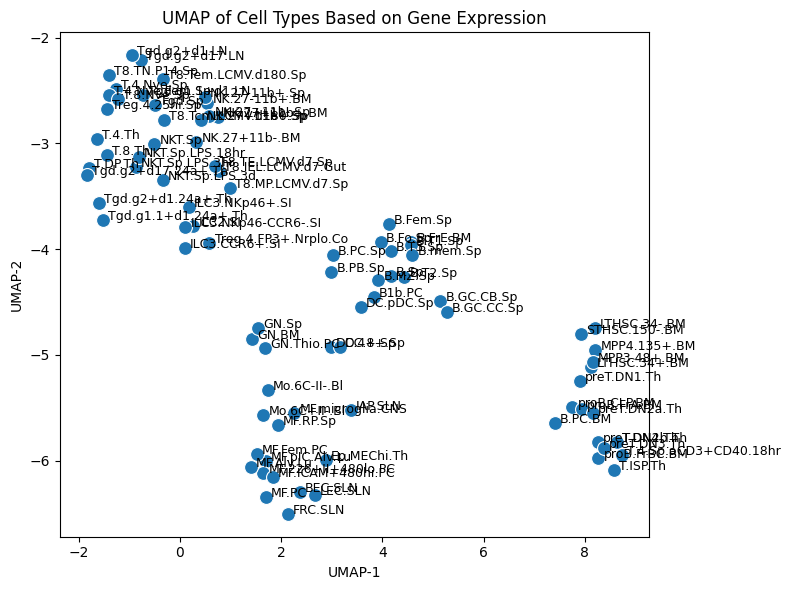

In [3]:
scaler = StandardScaler()
RNA_seq_scaled = scaler.fit_transform(RNA_T)

reducer = umap.UMAP(random_state=42)
umap_RNA_prep= reducer.fit_transform(RNA_seq_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_RNA_prep[:, 0], y=umap_RNA_prep[:, 1], s=100)


for i, label in enumerate(RNA_T.index):
    plt.text(umap_RNA_prep[i, 0]+0.1, umap_RNA_prep[i, 1], label, fontsize=9)

plt.title("UMAP of Cell Types Based on Gene Expression")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

Now that we have our UMAP we will perform and compare the elbow and silhouette method to determine the optimal amount of clusters for kmeans clustering

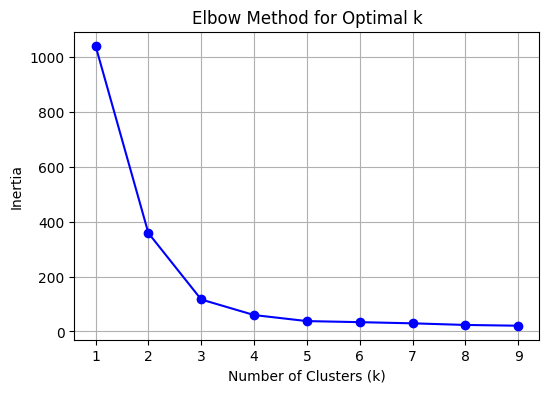

In [4]:
#elbow method to determine amount of clusters

inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(umap_RNA_prep)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

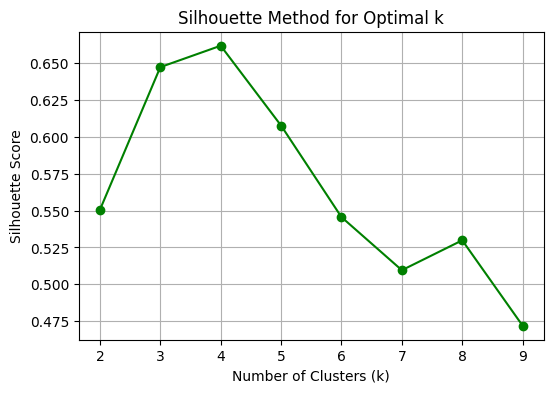

In [5]:
#test silhouette sore for kmeans clusterin

silhouette_scores = []

for k in range(2, 10):  # must be ≥2
    kmeans = KMeans(n_clusters=k, random_state=42).fit(umap_RNA_prep)
    labels = kmeans.labels_
    score = silhouette_score(umap_RNA_prep, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()

-> 2 and 3 cluster show elbows in the elbow method and 4 cluster shows the larest peak in their silhouette score, as far as these methods go this leaves us with no accurate prediction of the optimal number of clusters, we will try with 4 and 12 as that is the number of differetn cell lineages in our dtaset

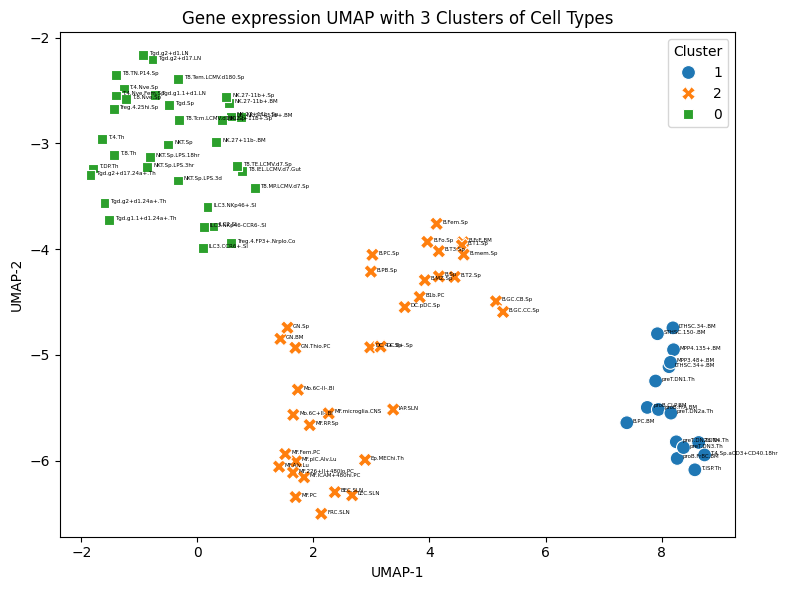

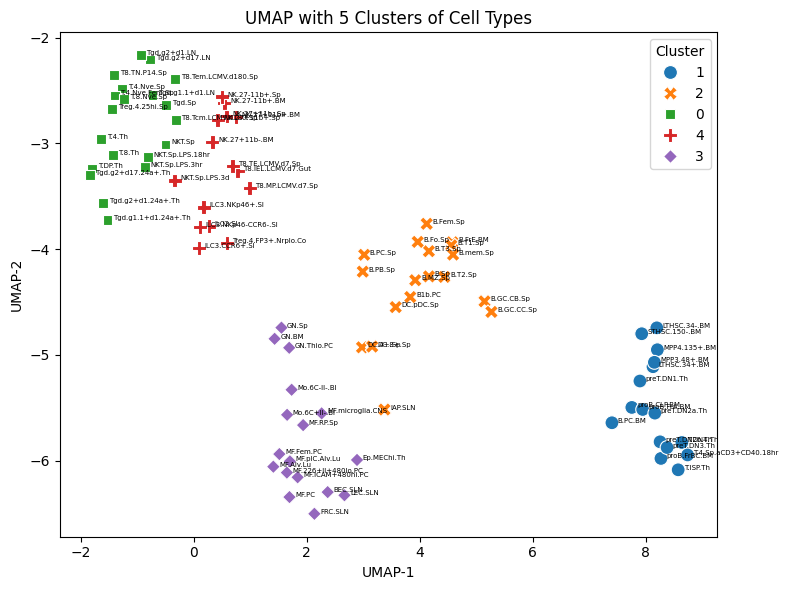

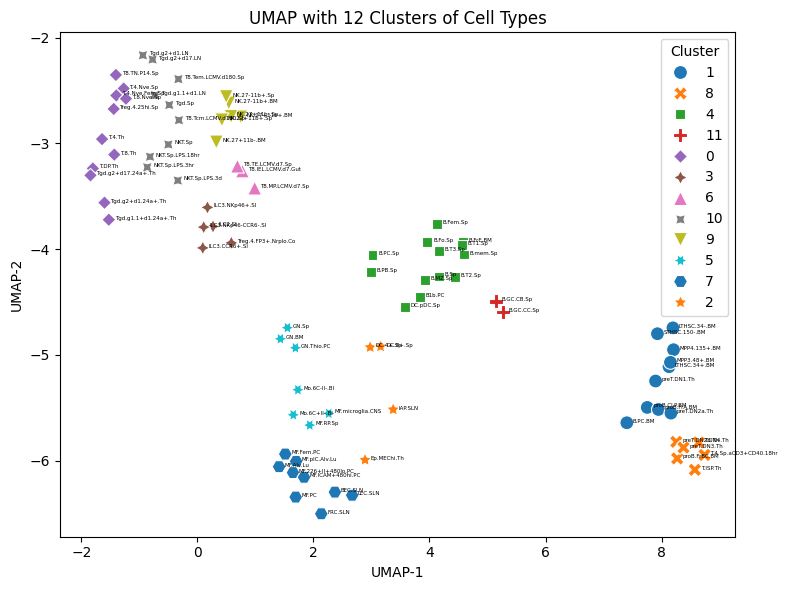


KMeans Clustering Summary (k=3):


,kmeans3,CellType
0,0,"[T.DP.Th, T.4.Th, T.8.Th, T.4.Nve.Sp, T.4.Nve...."
1,1,"[LTHSC.34-.BM, LTHSC.34+.BM, STHSC.150-.BM, MP..."
2,2,"[B.FrE.BM, B1b.PC, B.T1.Sp, B.T2.Sp, B.T3.Sp, ..."



KMeans Clustering Summary (k=5):


,kmeans5,CellType
0,0,"[T.DP.Th, T.4.Th, T.8.Th, T.4.Nve.Sp, T.4.Nve...."
1,1,"[LTHSC.34-.BM, LTHSC.34+.BM, STHSC.150-.BM, MP..."
2,2,"[B.FrE.BM, B1b.PC, B.T1.Sp, B.T2.Sp, B.T3.Sp, ..."
3,3,"[GN.BM, GN.Sp, GN.Thio.PC, Mo.6C+II-.Bl, Mo.6C..."
4,4,"[Treg.4.FP3+.Nrplo.Co, T8.IEL.LCMV.d7.Gut, T8...."



KMeans Clustering Summary (k=12):


,kmeans12,CellType
0,0,"[T.DP.Th, T.4.Th, T.8.Th, T.4.Nve.Sp, T.4.Nve...."
1,1,"[LTHSC.34-.BM, LTHSC.34+.BM, STHSC.150-.BM, MP..."
2,10,"[T8.Tcm.LCMV.d180.Sp, T8.Tem.LCMV.d180.Sp, NKT..."
3,11,"[B.GC.CB.Sp, B.GC.CC.Sp]"
4,2,"[DC.4+.Sp, DC.8+.Sp, IAP.SLN, Ep.MEChi.Th]"
5,3,"[Treg.4.FP3+.Nrplo.Co, ILC2.SI, ILC3.NKp46-CCR..."
6,4,"[B.FrE.BM, B1b.PC, B.T1.Sp, B.T2.Sp, B.T3.Sp, ..."
7,5,"[GN.BM, GN.Sp, GN.Thio.PC, Mo.6C+II-.Bl, Mo.6C..."
8,6,"[T8.IEL.LCMV.d7.Gut, T8.TE.LCMV.d7.Sp, T8.MP.L..."
9,7,"[MF.pIC.Alv.Lu, MF.226+II+480lo.PC, MF.ICAM+48..."


In [ ]:
umap_RNA_seq = pd.DataFrame(umap_RNA_prep, columns=["UMAP1", "UMAP2"], index=RNA_T.index)
umap_RNA_seq["CellType"] = RNA_T.index

qc_lineage_mapping = qc[['CellType', 'Lineage']].drop_duplicates(subset=['CellType'], keep='first')
qc_lineage_mapping.set_index('CellType', inplace=True)
adata.obs = adata.obs.merge(qc_lineage_mapping, left_index=True, right_index=True, how='left')
umap_RNA_seq = umap_RNA_seq.merge(qc_lineage_mapping, left_index=True, right_index=True, how='left')

# kmeans with 3 clusters
kmeans3 = KMeans(n_clusters=3, random_state=42)
umap_RNA_seq["kmeans3"] = kmeans3.fit_predict(umap_RNA_prep).astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_RNA_seq, x="UMAP1", y="UMAP2", hue="Lineage", style="kmeans3", s=100, palette="tab10")

for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["CellType"], fontsize=4)

plt.title("Gene expression UMAP with 3 Clusters of Cell Types")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# kmeans with 5 clusters
kmeans5 = KMeans(n_clusters=5, random_state=42)
umap_RNA_seq["kmeans5"] = kmeans5.fit_predict(umap_RNA_prep).astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_RNA_seq, x="UMAP1", y="UMAP2", hue="Lineage", style="kmeans5", s=100, palette="tab10")

for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["CellType"], fontsize=5)

plt.title("UMAP with 5 Clusters of Cell Types")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# kmeans with 12 clusters (amount cell types)
kmeans12 = KMeans(n_clusters=12, random_state=42)
umap_RNA_seq["kmeans12"] = kmeans12.fit_predict(umap_RNA_prep).astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_RNA_seq, x="UMAP1", y="UMAP2", hue="Lineage", style="kmeans12", s=100, palette="tab10")

for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["CellType"], fontsize=4)

plt.title("UMAP with 12 Clusters of Cell Types")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# table view of cell types
for k in [3, 5, 12]:
    cluster_col = f"kmeans{k}"
    kmeans_summary = umap_RNA_seq.groupby(cluster_col)["CellType"].apply(list).reset_index()
    print(f"\nKMeans Clustering Summary (k={k}):")
    display(kmeans_summary)


now we will perform leiden clustering to see how it compares

c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



qc_lineage_mapping after dropping duplicates and setting index:
                                  Lineage
CellType                                
LTHSC.34-.BM                   Stem&Prog
LTHSC.34+.BM                   Stem&Prog
STHSC.150-.BM                  Stem&Prog
MPP4.135+.BM                   Stem&Prog
proB.CLP.BM                            B
...                                  ...
FRC.CD140a+.Madcam-.CD35-.SLN     stroma
IAP.SLN                           stroma
BEC.SLN                           stroma
LEC.SLN                           stroma
Ep.MEChi.Th                       stroma

[90 rows x 1 columns]

umap_RNA_seq head with merged Lineage:
                   UMAP1     UMAP2    Lineage
LTHSC.34-.BM   8.195832 -4.743562  Stem&Prog
LTHSC.34+.BM   8.128364 -5.111130  Stem&Prog
STHSC.150-.BM  7.928847 -4.799310  Stem&Prog
MPP4.135+.BM   8.205855 -4.950552  Stem&Prog
proB.CLP.BM    7.753726 -5.496077          B


C:\Users\helen\AppData\Local\Temp\ipykernel_26096\1136496146.py:21: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.9)


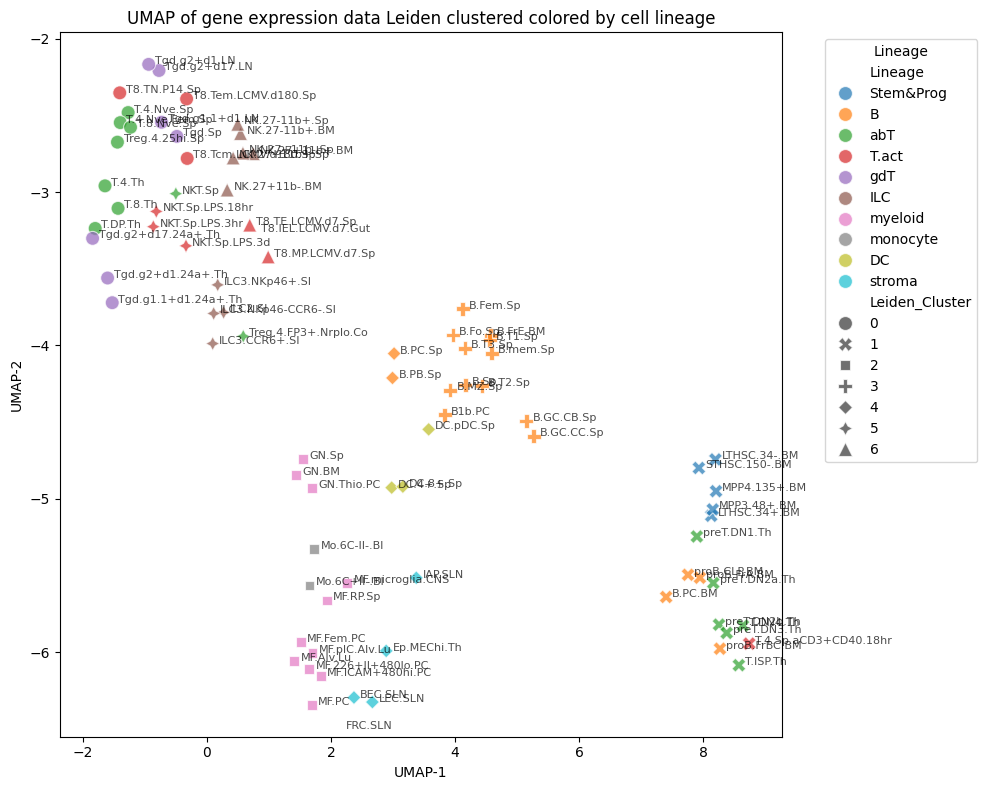


Plotting UMAP with Scanpy for comparison (colored by Lineage):


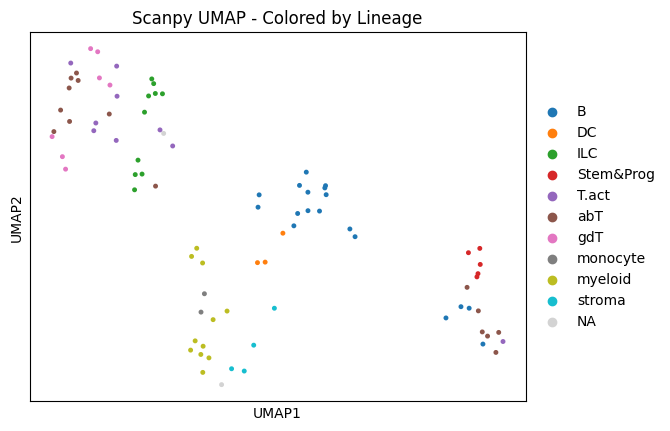


Plotting UMAP with Scanpy for comparison (colored by Leiden Clusters):


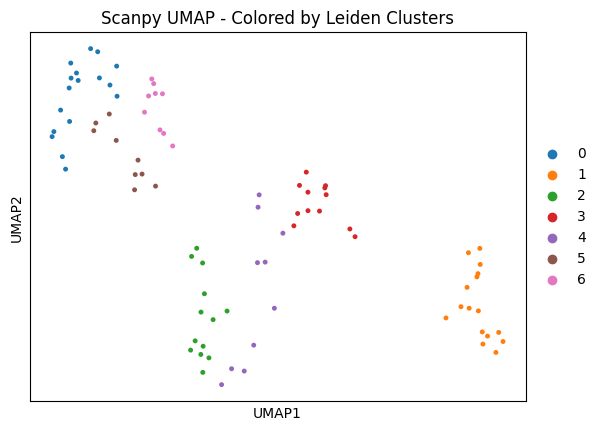

In [ ]:
umap_RNA_seq = pd.DataFrame(umap_RNA_prep, columns=["UMAP1", "UMAP2"], index=RNA_T.index)
adata = ad.AnnData(X=RNA_T.values)
adata.obs_names = RNA_T.index
adata.obsm["X_umap"] = umap_RNA_prep
adata.var_names= RNA_T.columns

scaler = StandardScaler()
RNA_scaled = scaler.fit_transform(RNA_T)
umap_model = umap.UMAP(random_state=42)
umap_result = umap_model.fit_transform(RNA_scaled)
adata.obsm['X_umap'] = umap_result

print("\nqc_lineage_mapping after dropping duplicates and setting index:\n", qc_lineage_mapping)
print("\numap_RNA_seq head with merged Lineage:\n", umap_RNA_seq.head())

sc.pp.neighbors(adata, use_rep="X", n_neighbors=10, random_state=42)
sc.tl.leiden(adata, resolution=1.9)

umap_RNA_seq["Leiden_Cluster"] = adata.obs["leiden"].values
umap_RNA_seq["Leiden_Cluster"].to_csv("leiden_clusters.csv")


plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_RNA_seq, x="UMAP1", y="UMAP2",
    hue="Lineage", style="Leiden_Cluster",
    s=100, palette="tab10",alpha=0.7
)
for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row.name, fontsize=8, alpha=0.7)

plt.title("UMAP of gene expression data Leiden clustered colored by cell lineage")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Lineage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nPlotting UMAP with Scanpy for comparison (colored by Lineage):")
adata.obs['Lineage'] = adata.obs['Lineage'].astype('category')
sc.pl.umap(adata, color='Lineage', title="Scanpy UMAP - Colored by Lineage", size=50)

print("\nPlotting UMAP with Scanpy for comparison (colored by Leiden Clusters):")
adata.obs['leiden'] = adata.obs['leiden'].astype('category') # Ensure Leiden is categorical
sc.pl.umap(adata, color='leiden', title="Scanpy UMAP - Colored by Leiden Clusters", size=50)

we will visualize grouped cell types in a table and countplot

C:\Users\helen\AppData\Local\Temp\ipykernel_26096\235263374.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clustered_cell_types = umap_RNA_seq.groupby(leiden_col).apply(lambda RNA_seq: list(RNA_seq.index))
C:\Users\helen\AppData\Local\Temp\ipykernel_26096\235263374.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clustered_cell_types = umap_RNA_seq.groupby(leiden_col).apply(lambda RNA_seq: list(RNA_seq.index))
C:\Users\helen\AppData\Local\Temp\ipykernel_26096\235263374.py:17: FutureWarning: 

Passing `pal


Cluster 0:
  - T.DP.Th
  - T.4.Th
  - T.8.Th
  - T.4.Nve.Sp
  - T.4.Nve.Fem.Sp
  - T.8.Nve.Sp
  - Treg.4.25hi.Sp
  - T8.TN.P14.Sp
  - T8.Tcm.LCMV.d180.Sp
  - T8.Tem.LCMV.d180.Sp
  - Tgd.g2+d17.24a+.Th
  - Tgd.g2+d17.LN
  - Tgd.g2+d1.24a+.Th
  - Tgd.g2+d1.LN
  - Tgd.g1.1+d1.24a+.Th
  - Tgd.g1.1+d1.LN
  - Tgd.Sp

Cluster 1:
  - LTHSC.34-.BM
  - LTHSC.34+.BM
  - STHSC.150-.BM
  - MPP4.135+.BM
  - proB.CLP.BM
  - proB.FrA.BM
  - proB.FrBC.BM
  - B.PC.BM
  - preT.DN1.Th
  - preT.DN2a.Th
  - preT.DN2b.Th
  - preT.DN3.Th
  - T.DN4.Th
  - T.ISP.Th
  - T.4.Sp.aCD3+CD40.18hr
  - MPP3.48+.BM

Cluster 2:
  - GN.BM
  - GN.Sp
  - GN.Thio.PC
  - Mo.6C+II-.Bl
  - Mo.6C-II-.Bl
  - MF.pIC.Alv.Lu
  - MF.226+II+480lo.PC
  - MF.ICAM+480hi.PC
  - MF.RP.Sp
  - MF.Alv.Lu
  - MF.microglia.CNS
  - MF.PC
  - MF.Fem.PC

Cluster 3:
  - B.FrE.BM
  - B1b.PC
  - B.T1.Sp
  - B.T2.Sp
  - B.T3.Sp
  - B.Sp
  - B.Fem.Sp
  - B.MZ.Sp
  - B.Fo.Sp
  - B.mem.Sp
  - B.GC.CB.Sp
  - B.GC.CC.Sp

Cluster 4:
  - B.PB.Sp
  - B.PC.Sp

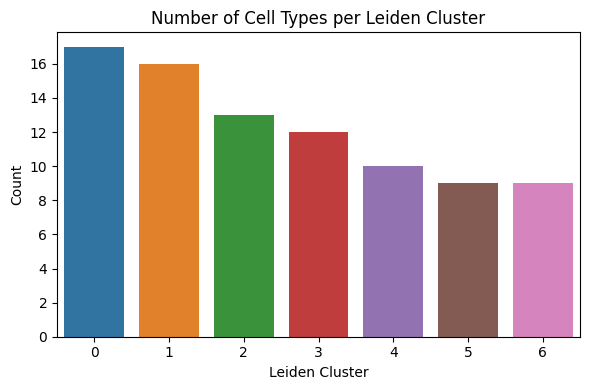


Leiden Clustering Summary:


,Leiden_Cluster,CellType
0,0,"[T.DP.Th, T.4.Th, T.8.Th, T.4.Nve.Sp, T.4.Nve...."
1,1,"[LTHSC.34-.BM, LTHSC.34+.BM, STHSC.150-.BM, MP..."
2,2,"[GN.BM, GN.Sp, GN.Thio.PC, Mo.6C+II-.Bl, Mo.6C..."
3,3,"[B.FrE.BM, B1b.PC, B.T1.Sp, B.T2.Sp, B.T3.Sp, ..."
4,4,"[B.PB.Sp, B.PC.Sp, DC.4+.Sp, DC.8+.Sp, DC.pDC...."
5,5,"[Treg.4.FP3+.Nrplo.Co, NKT.Sp, NKT.Sp.LPS.3hr,..."
6,6,"[T8.IEL.LCMV.d7.Gut, T8.TE.LCMV.d7.Sp, T8.MP.L..."


In [8]:
leiden_col = "Leiden_Cluster"
if leiden_col not in umap_RNA_seq.columns:
    umap_RNA_seq[leiden_col] = adata.obs["leiden"].values

# Add CellType column if missing
if "CellType" not in umap_RNA_seq.columns:
    umap_RNA_seq["CellType"] = umap_RNA_seq.index

clustered_cell_types = umap_RNA_seq.groupby(leiden_col).apply(lambda RNA_seq: list(RNA_seq.index))

for cluster, cells in clustered_cell_types.items():
    print(f"\nCluster {cluster}:")
    for cell in cells:
        print(f"  - {cell}")

plt.figure(figsize=(6, 4))
sns.countplot(x=leiden_col, data=umap_RNA_seq, palette="tab10")
plt.title("Number of Cell Types per Leiden Cluster")
plt.xlabel("Leiden Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

umap_RNA_seq["Leiden_Cluster"] = adata.obs["leiden"].astype(str).reindex(umap_RNA_seq.index)
leiden_summary = umap_RNA_seq.groupby(leiden_col)["CellType"].apply(list).reset_index()
print("\nLeiden Clustering Summary:")
display(leiden_summary)


now we will correlate leiden/kmeans clusters with their celltype/ lineage

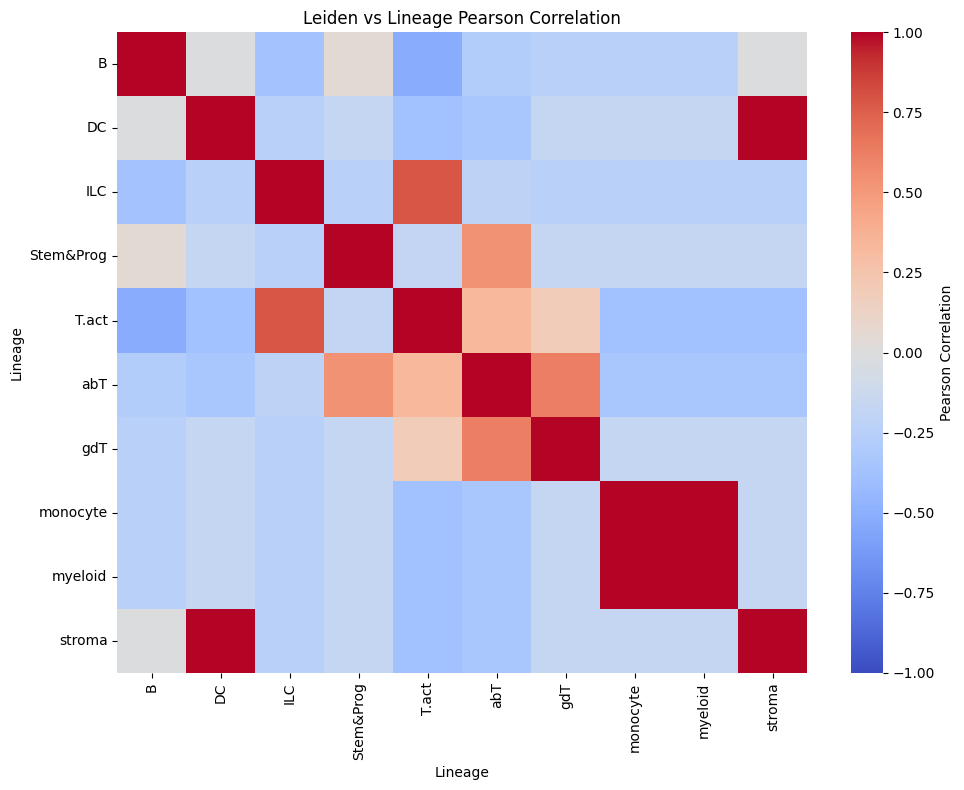

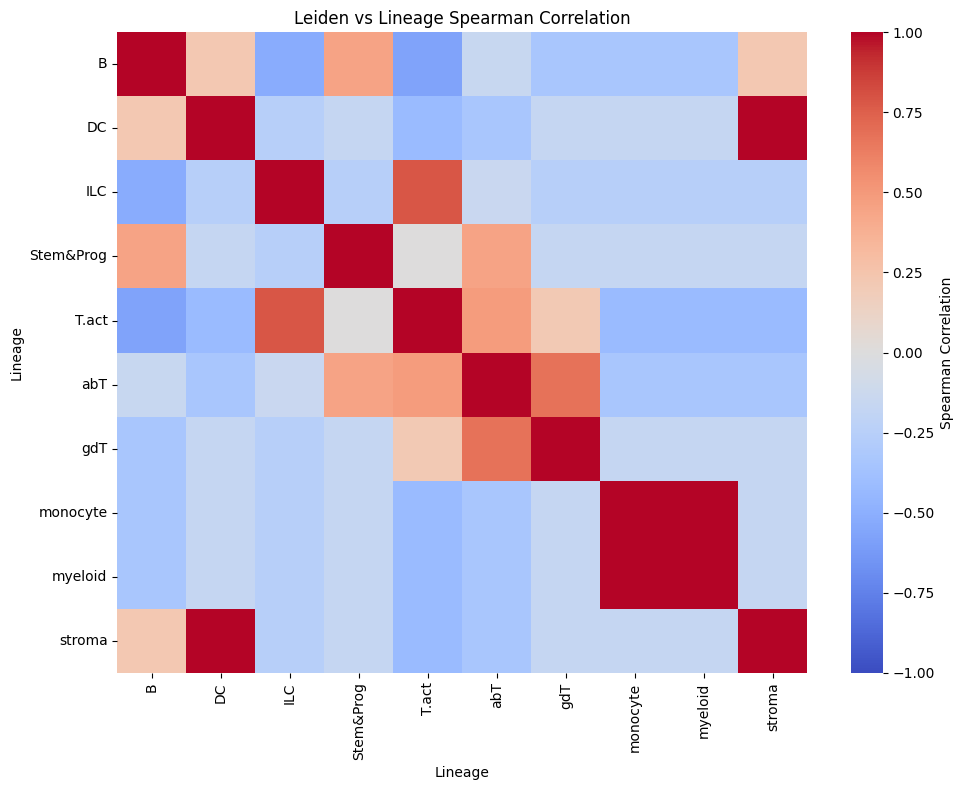

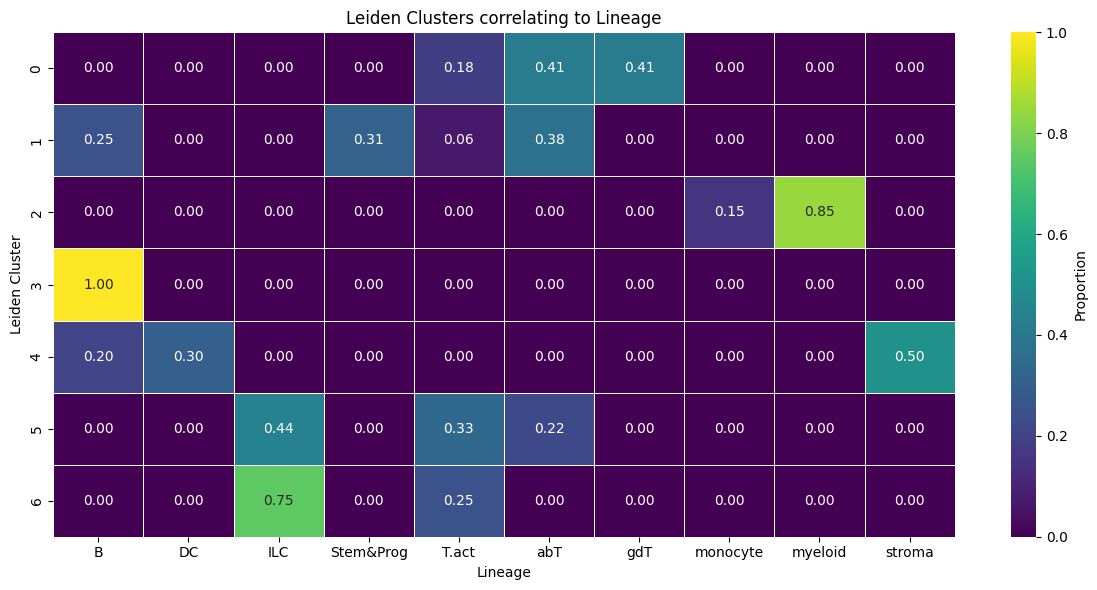

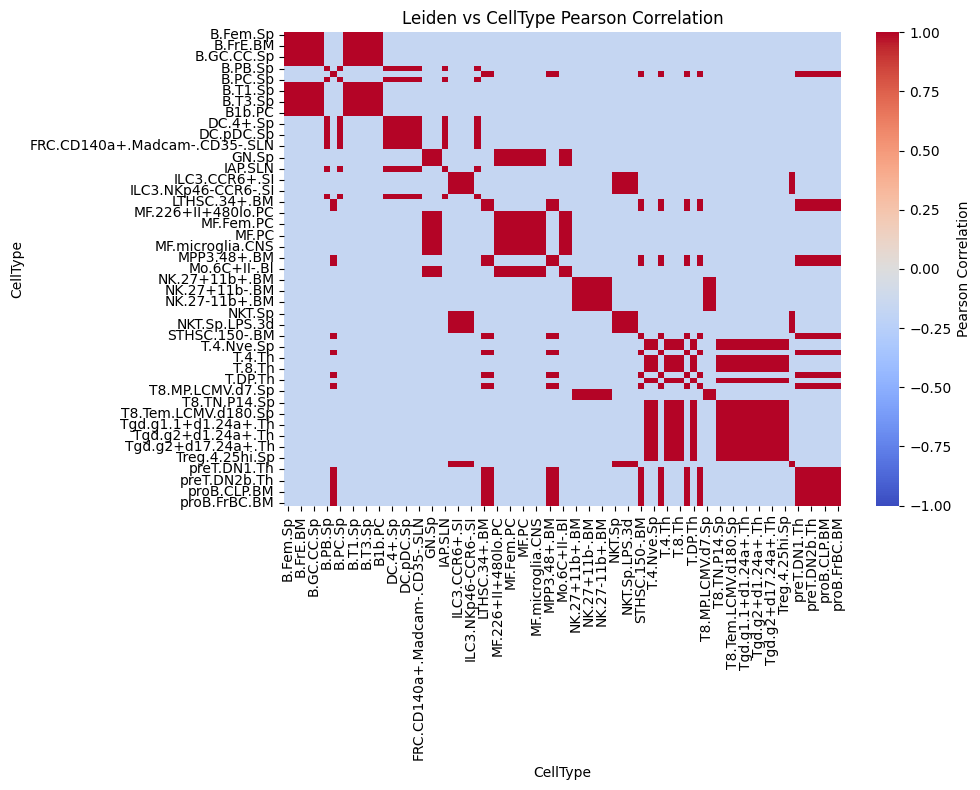

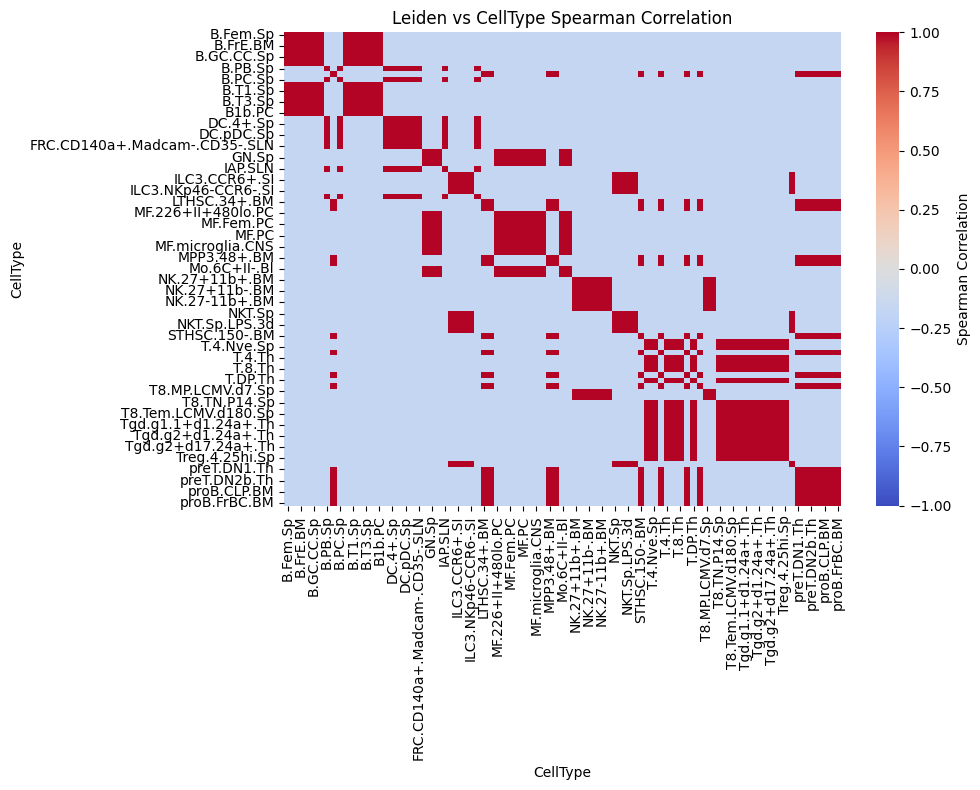

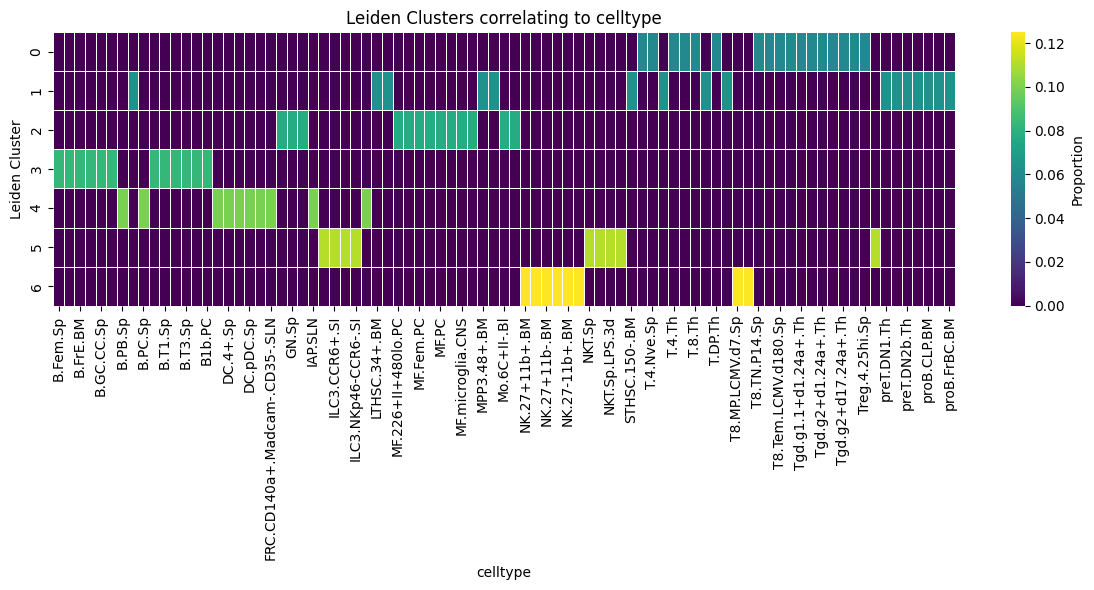

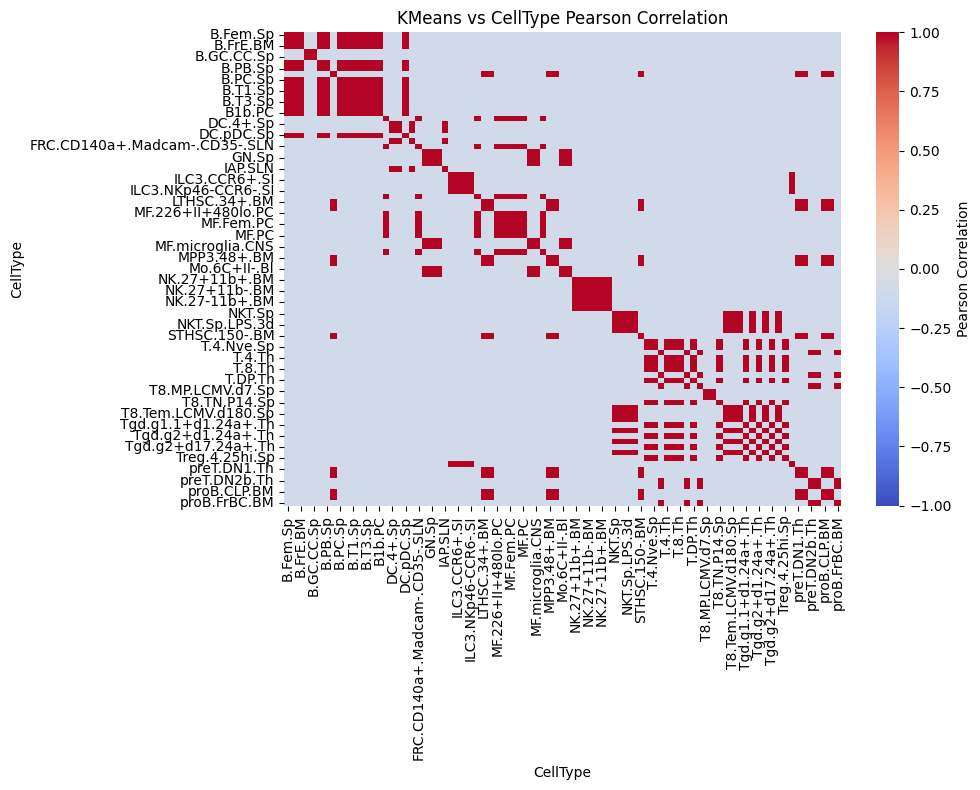

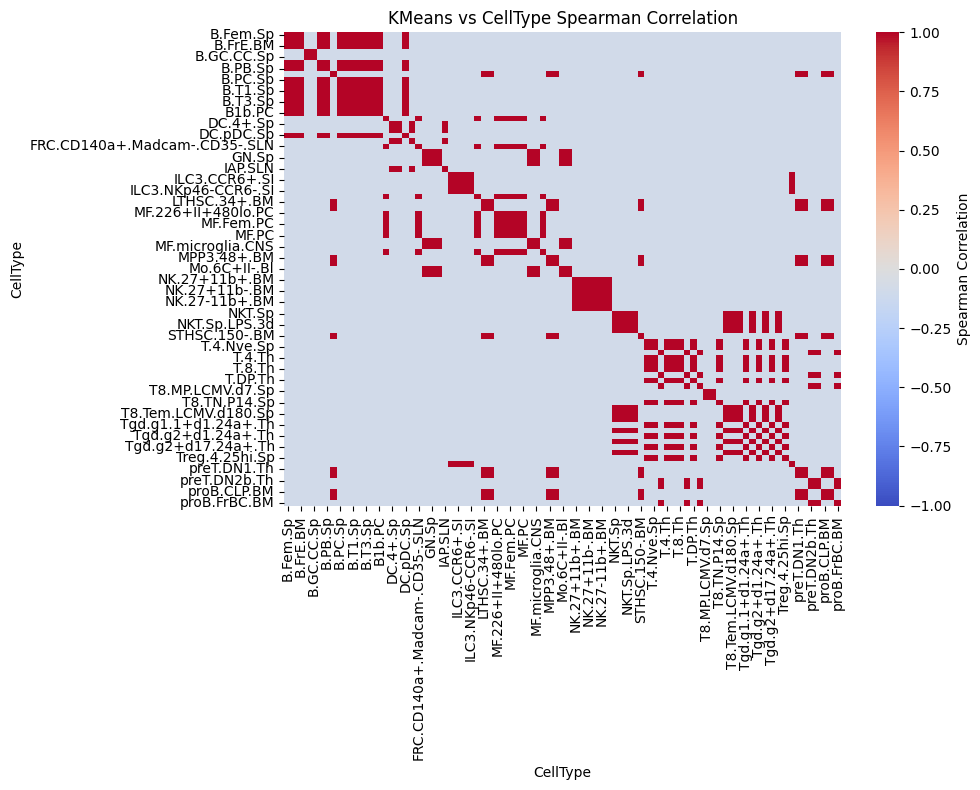

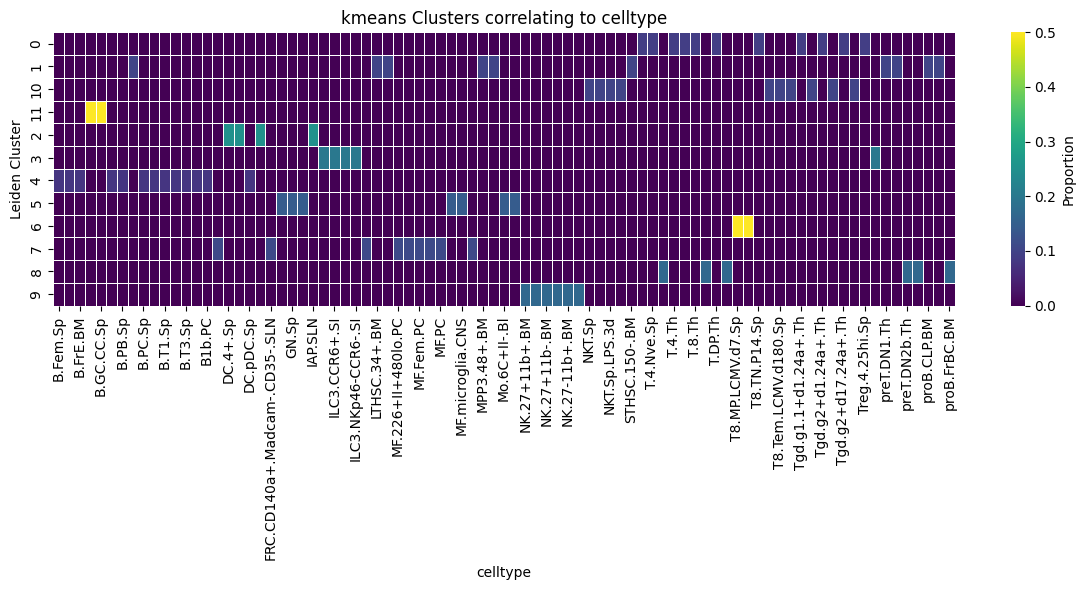

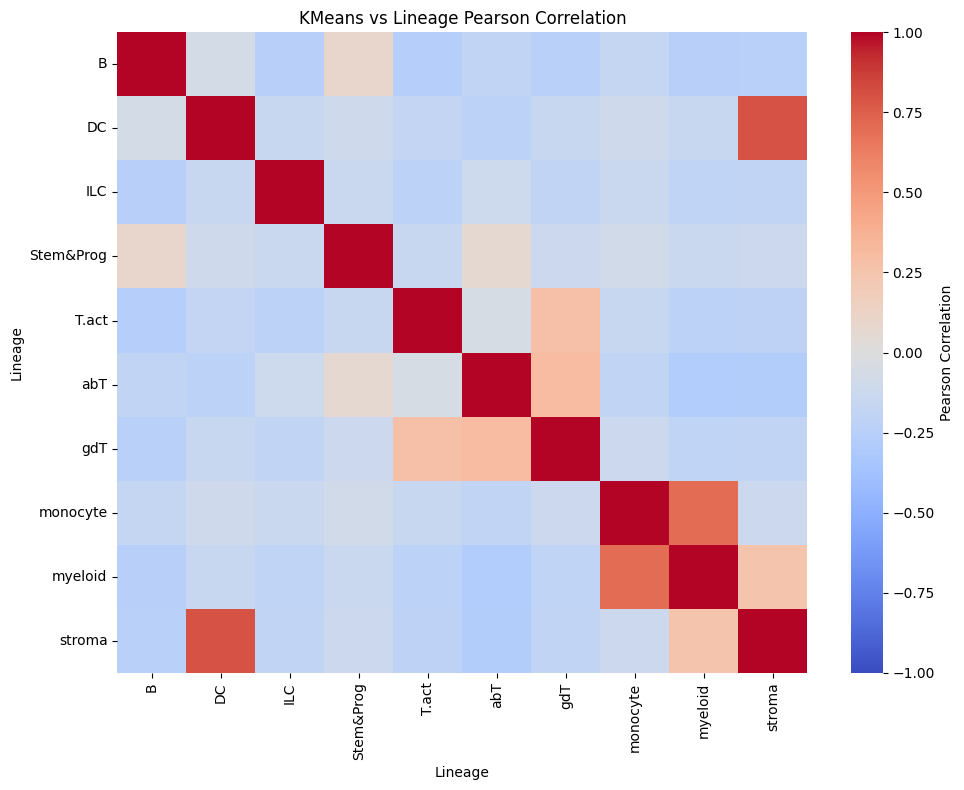

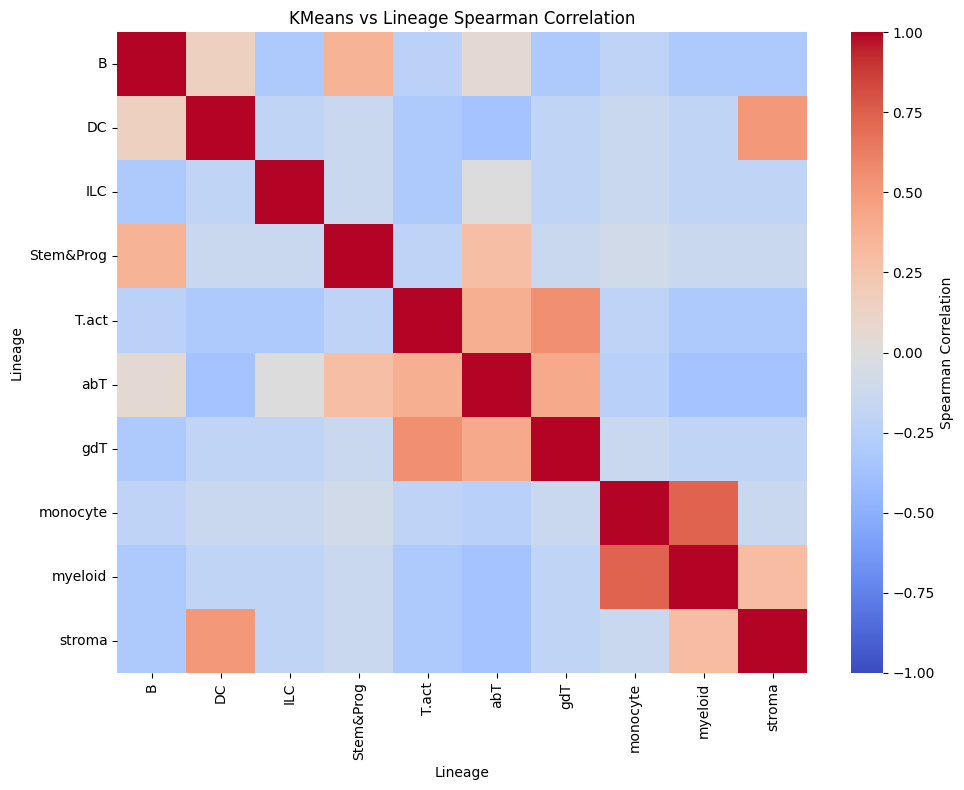

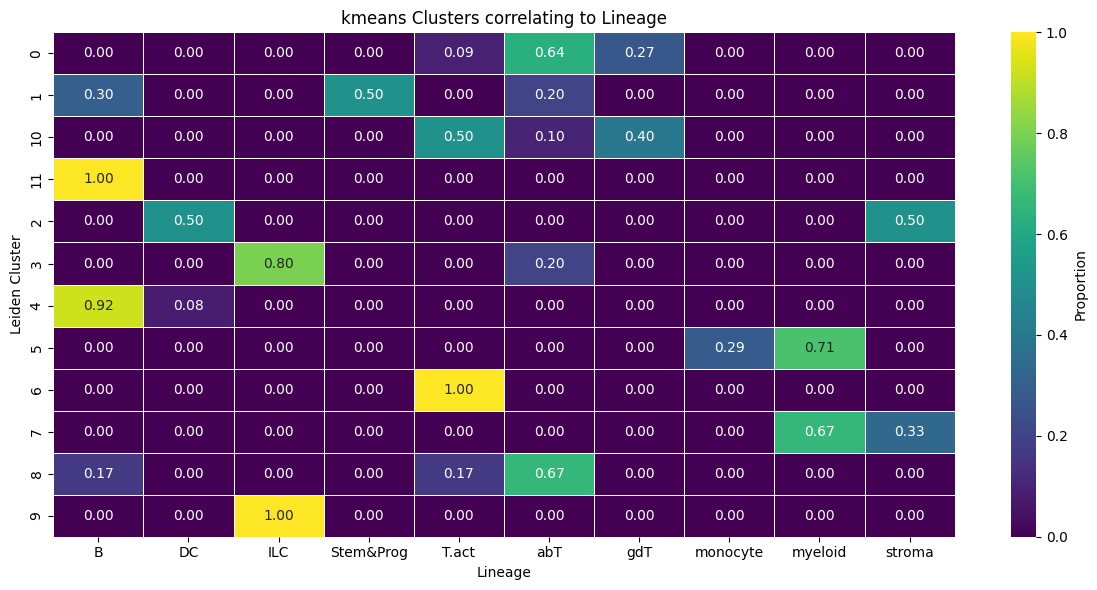

In [9]:
sc.pp.neighbors(adata, use_rep="X", n_neighbors=10, random_state=42)
sc.tl.leiden(adata, resolution=1.9)

# Assign Leiden clusters by index, so only matching samples get a label
umap_RNA_seq["Leiden_Cluster"] = adata.obs["leiden"]
umap_RNA_seq["Leiden_Cluster"].to_csv("leiden_clusters.csv")

#spearman & perason correlation
def compute_and_plot_correlations(ct_norm, title_prefix=""):
    import scipy.stats as stats

    pearson_corr = ct_norm.corr(method='pearson')
    spearman_corr = ct_norm.corr(method='spearman')

    # Plot Pearson
    plt.figure(figsize=(10, 8))
    sns.heatmap(pearson_corr, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f",
                cbar_kws={"label": "Pearson Correlation"})
    plt.title(f"{title_prefix} Pearson Correlation")
    plt.tight_layout()
    plt.show()

    # Plot Spearman
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_corr, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f",
                cbar_kws={"label": "Spearman Correlation"})
    plt.title(f"{title_prefix} Spearman Correlation")
    plt.tight_layout()
    plt.show()
    
    return pearson_corr, spearman_corr


# heatmap correlation leiden clusters and lineage 

qc.index = qc.index.str.replace(r"#\d+", "", regex=True)
adata.obs_names = adata.obs_names.str.replace(r"#\d+", "", regex=True)

# Drop duplicate indices to avoid reindex error
qc = qc.loc[~qc.index.duplicated(keep='first')]
adata = adata[~adata.obs_names.duplicated(keep='first')].copy()

common_samples = adata.obs_names.intersection(qc.index)
adata = adata[common_samples].copy()
qc_matched = qc.loc[common_samples]

celltype_to_lineage = qc_matched["Lineage"].to_dict()
adata.obs["Lineage"] = adata.obs_names.map(celltype_to_lineage).fillna("Unknown")

ct = pd.crosstab(adata.obs["leiden"], adata.obs["Lineage"])
ct_norm = ct.div(ct.sum(axis=1), axis=0) 
compute_and_plot_correlations(ct_norm, title_prefix="Leiden vs Lineage")

plt.figure(figsize=(12, 6))
sns.heatmap(ct_norm, cmap="viridis", linewidths=0.5, annot=True, fmt=".2f",cbar_kws={"label": "Proportion"})
plt.title("Leiden Clusters correlating to Lineage")
plt.xlabel("Lineage")
plt.ylabel("Leiden Cluster")
plt.tight_layout()
plt.show()

# correlation leiden clusters and cell type
adata.obs["CellType"] = qc_matched["CellType"]
ct = pd.crosstab(adata.obs["leiden"], adata.obs["CellType"])
ct_norm = ct.div(ct.sum(axis=1), axis=0) 
compute_and_plot_correlations(ct_norm, title_prefix="Leiden vs CellType")

plt.figure(figsize=(12, 6))
sns.heatmap(ct_norm, cmap="viridis", linewidths=0.5,cbar_kws={"label": "Proportion"})
plt.title("Leiden Clusters correlating to celltype")
plt.xlabel("celltype")
plt.ylabel("Leiden Cluster")
plt.tight_layout()
plt.show()

#now kmeans
from sklearn.cluster import KMeans

# Prepare DataFrame
umap_RNA_seq = pd.DataFrame(umap_RNA_prep, columns=["UMAP1", "UMAP2"], index=RNA_T.index)
umap_RNA_seq["CellType"] = RNA_T.index

# kmeans with 12 clusters (amount cell types)
kmeans12 = KMeans(n_clusters=12, random_state=42)
umap_RNA_seq["kmeans12"] = kmeans12.fit_predict(umap_RNA_prep).astype(str)
adata.obs['kmeans12'] = umap_RNA_seq.loc[adata.obs_names, 'kmeans12']

#kmeans12 vs celltype
ct = pd.crosstab(adata.obs["kmeans12"], adata.obs["CellType"])
ct_norm = ct.div(ct.sum(axis=1), axis=0) 
compute_and_plot_correlations(ct_norm, title_prefix="KMeans vs CellType")

plt.figure(figsize=(12, 6))
sns.heatmap(ct_norm, cmap="viridis", linewidths=0.5,cbar_kws={"label": "Proportion"})
plt.title("kmeans Clusters correlating to celltype")
plt.xlabel("celltype")
plt.ylabel("Leiden Cluster")
plt.tight_layout()
plt.show()

#kmeans12 vs cell lineage
ct = pd.crosstab(adata.obs["kmeans12"], adata.obs["Lineage"])
ct_norm = ct.div(ct.sum(axis=1), axis=0) 
compute_and_plot_correlations(ct_norm, title_prefix="KMeans vs Lineage")

plt.figure(figsize=(12, 6))
sns.heatmap(ct_norm, cmap="viridis", linewidths=0.5, annot=True, fmt=".2f",cbar_kws={"label": "Proportion"})
plt.title("kmeans Clusters correlating to Lineage")
plt.xlabel("Lineage")
plt.ylabel("Leiden Cluster")
plt.tight_layout()
plt.show()


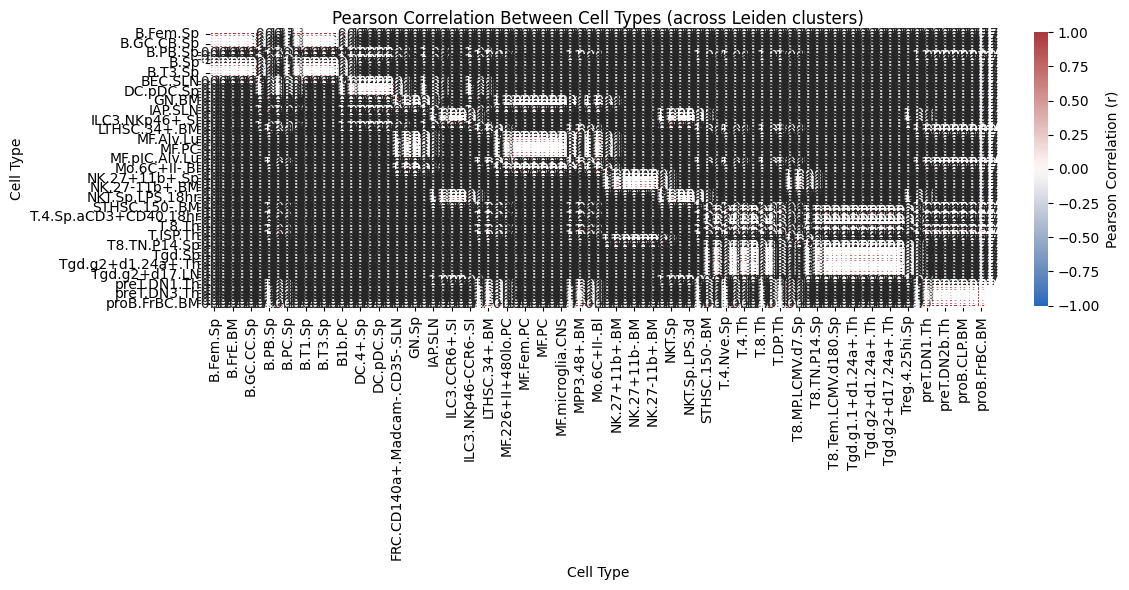

In [10]:
# Leiden Clusters correlating to Lineage heatmap but with pearson coefficient instead of percentage
ct = pd.crosstab(adata.obs["leiden"], adata.obs["CellType"])
ct_norm = ct.div(ct.sum(axis=1), axis=0)
corr = ct_norm.corr(method="pearson")  

plt.figure(figsize=(12, 6))
sns.heatmap(
    corr,
    annot=True, fmt=".2f", cmap="vlag", center=0, vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation (r)"}
)
plt.title("Pearson Correlation Between Cell Types (across Leiden clusters)")
plt.xlabel("Cell Type")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()


now we will compare clustering via leiden and kmeans

In [11]:
# Ensure Leiden cluster assignments are present and as string
if "Leiden_Cluster" not in umap_RNA_seq.columns:
	umap_RNA_seq["Leiden_Cluster"] = adata.obs["leiden"].astype(str).reindex(umap_RNA_seq.index)
else:
	umap_RNA_seq["Leiden_Cluster"] = umap_RNA_seq["Leiden_Cluster"].astype(str)

kmeans5_labels = kmeans5.fit_predict(umap_RNA_prep)
umap_RNA_seq["KMeans_Cluster"] = kmeans5_labels.astype(str)

# Drop rows with NaN in either cluster column
valid = umap_RNA_seq[["Leiden_Cluster", "KMeans_Cluster"]].dropna()
ari = adjusted_rand_score(valid["Leiden_Cluster"], valid["KMeans_Cluster"])
nmi = normalized_mutual_info_score(valid["Leiden_Cluster"], valid["KMeans_Cluster"])

print(f"Adjusted Rand Index (KMeans vs. Leiden): {ari:.3f}")
print(f"Normalized Mutual Information (KMeans vs. Leiden): {nmi:.3f}")

Adjusted Rand Index (KMeans vs. Leiden): 0.736
Normalized Mutual Information (KMeans vs. Leiden): 0.829


now were correlating cell lineage to genes in a heatmap with a dendogram

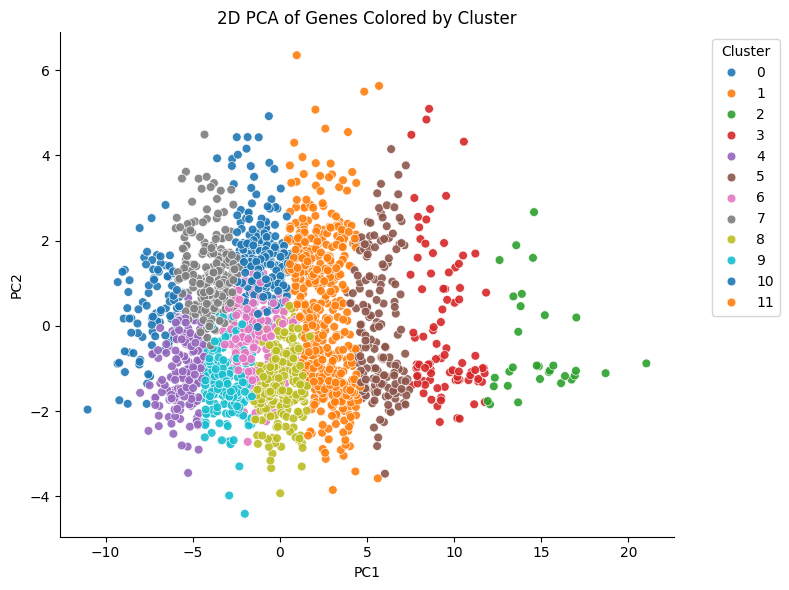

c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


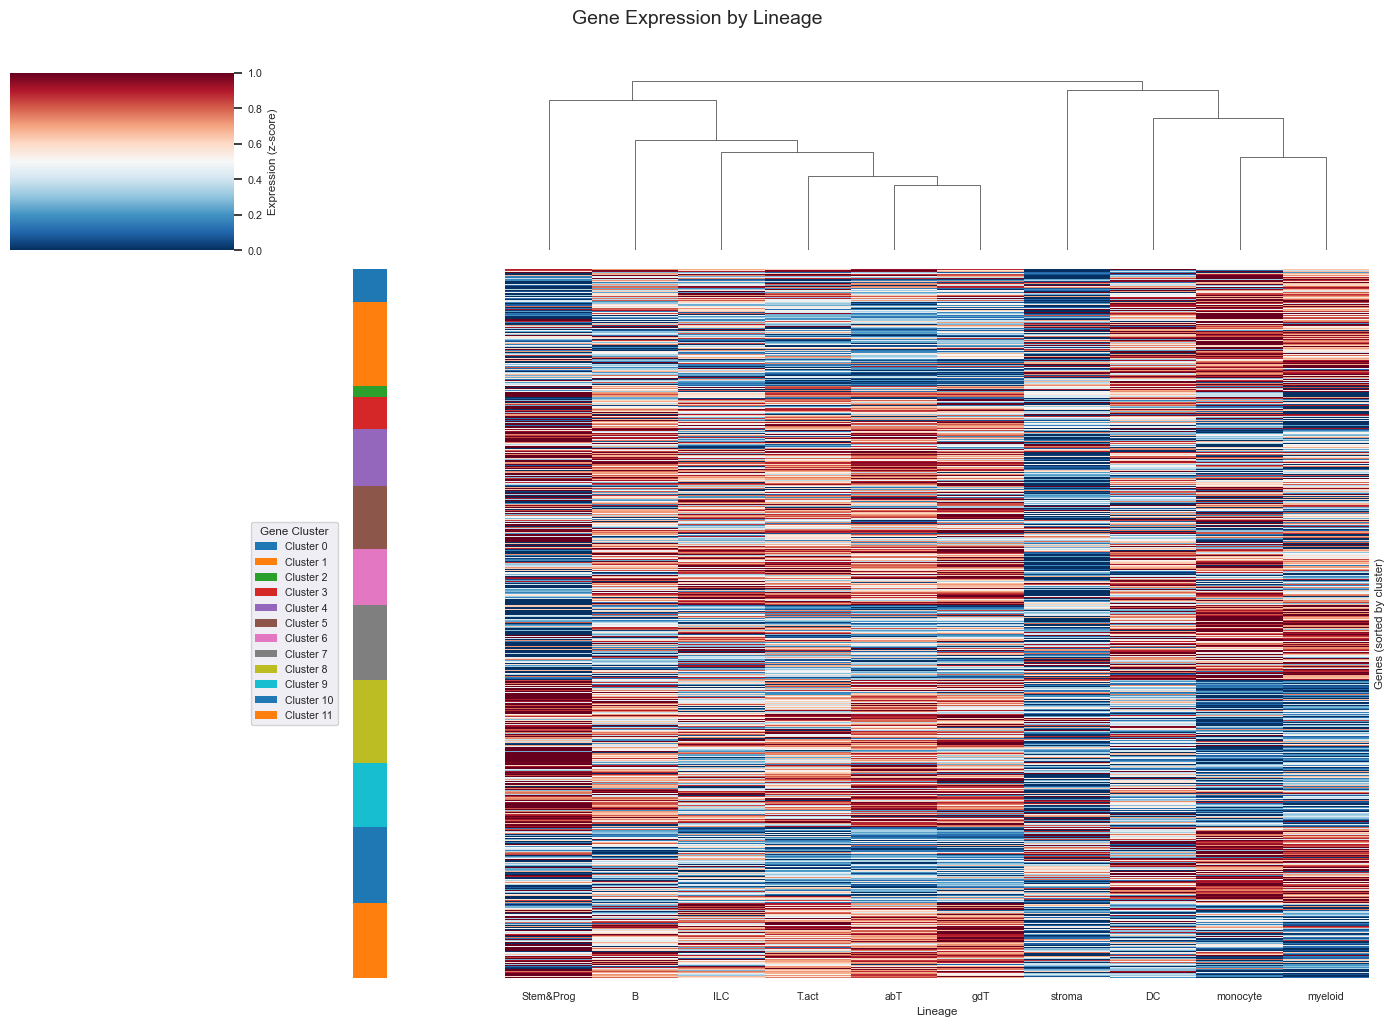

In [12]:
def get_lineage_expression(RNA_seq_T, adata, top_n_genes=2000):
    common_samples = RNA_seq_T.index.intersection(adata.obs_names)
    if len(common_samples) == 0:
        raise ValueError("No common samples between RNA_seq_T and adata.obs_names.")
    RNA_df = RNA_seq_T.loc[common_samples]
    lineage_info = adata.obs.loc[common_samples, "Lineage"]
    lineage_expr = RNA_df.groupby(lineage_info).mean().T
    top_genes = lineage_expr.var(axis=1).nlargest(top_n_genes).index
    return lineage_expr.loc[top_genes]

def cluster_and_pca(lineage_expr, n_gene_clusters=12, n_pca_components=10):
    # PCA
    pca = PCA(n_components=n_pca_components)
    lineage_expr_pca = pd.DataFrame(
        pca.fit_transform(lineage_expr),
        index=lineage_expr.index,
        columns=[f"PC{i+1}" for i in range(n_pca_components)]
    )
    # KMeans
    kmeans = KMeans(n_clusters=n_gene_clusters, random_state=42)
    gene_clusters = kmeans.fit_predict(lineage_expr)
    gene_cluster_series = pd.Series(gene_clusters, index=lineage_expr.index)
    return lineage_expr_pca, gene_cluster_series

def plot_pca_clusters(lineage_expr, gene_cluster_series, cluster_palette):
    # 2D PCA
    pca_2d = PCA(n_components=2)
    pca_coords_2d = pca_2d.fit_transform(lineage_expr)
    pca_df_2d = pd.DataFrame(pca_coords_2d, index=lineage_expr.index, columns=["PC1", "PC2"])
    pca_df_2d["Cluster"] = gene_cluster_series
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=pca_df_2d, x="PC1", y="PC2", hue="Cluster",
        palette=cluster_palette, legend="full", s=40, alpha=0.9
    )
    plt.title("2D PCA of Genes Colored by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_clustermap(lineage_expr, gene_cluster_series, lineage_expr_pca, cluster_palette):
    gene_cluster_df = gene_cluster_series.rename("Cluster").to_frame()
    gene_cluster_with_pc1 = gene_cluster_df.join(lineage_expr_pca["PC1"])
    sorted_genes = gene_cluster_with_pc1.sort_values(["Cluster", "PC1"]).index
    lineage_expr_sorted = lineage_expr.loc[sorted_genes]
    row_colors_sorted = gene_cluster_series.loc[sorted_genes].map(cluster_palette)
    sns.set(font_scale=0.7)
    g = sns.clustermap(
        lineage_expr_sorted,
        row_colors=row_colors_sorted,
        cmap="RdBu_r",
        standard_scale=0,
        figsize=(14, 10),
        col_cluster=True,
        row_cluster=False,
        yticklabels=False,
        xticklabels=True,
        cbar_kws={"label": "Expression (z-score)"}
    )
    g.ax_heatmap.set_ylabel("Genes (sorted by cluster)")
    g.ax_heatmap.set_xlabel("Lineage")
    g.fig.suptitle("Gene Expression by Lineage", fontsize=14, y=1.02)
    # Custom legend for clusters
    for cluster_id, color in cluster_palette.items():
        g.ax_row_dendrogram.bar(0, 0, color=color, label=f"Cluster {cluster_id}", linewidth=0)
    g.ax_row_dendrogram.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="Gene Cluster")
    plt.tight_layout()
    plt.show()

# Main workflow
lineage_expr = get_lineage_expression(RNA_T, adata, top_n_genes=2000)
n_gene_clusters = 12 #changable
n_pca_components = 10 #changable

lineage_expr_pca, gene_cluster_series = cluster_and_pca(lineage_expr, n_gene_clusters=n_gene_clusters, n_pca_components=n_pca_components)
cluster_colors = sns.color_palette("tab10", n_colors=n_gene_clusters)
cluster_palette = dict(zip(range(n_gene_clusters), cluster_colors))

plot_pca_clusters(lineage_expr, gene_cluster_series, cluster_palette)
plot_clustermap(lineage_expr, gene_cluster_series, lineage_expr_pca, cluster_palette)


correlating atac and rna clusters in heatmap

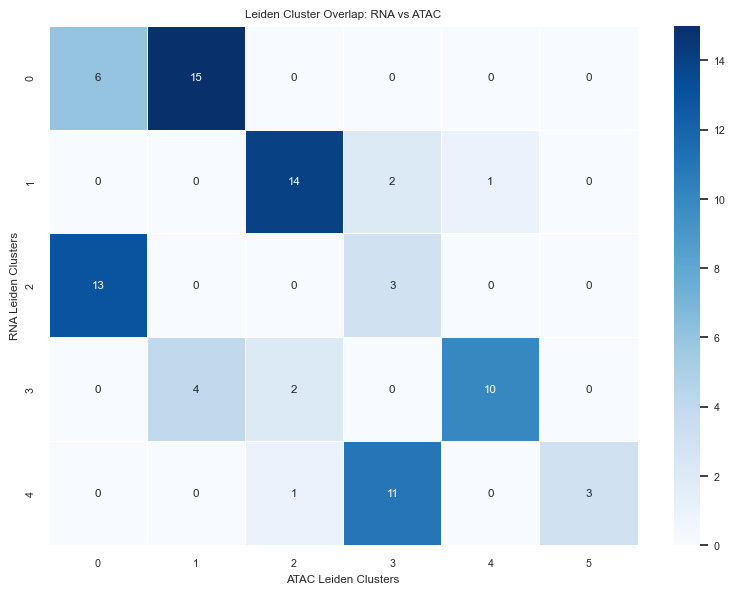

C:\Users\helen\AppData\Local\Temp\ipykernel_26096\3197934739.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  RNA_cluster_avg = RNA_profiles.groupby('cluster').mean()
C:\Users\helen\AppData\Local\Temp\ipykernel_26096\3197934739.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ATAC_cluster_avg = ATAC_profiles.groupby('cluster').mean()


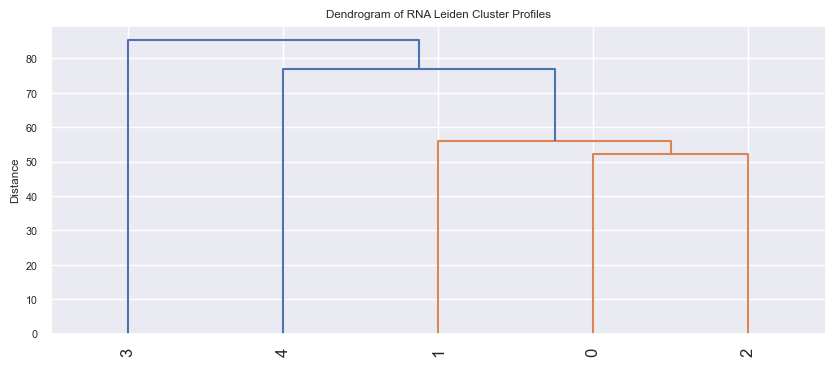

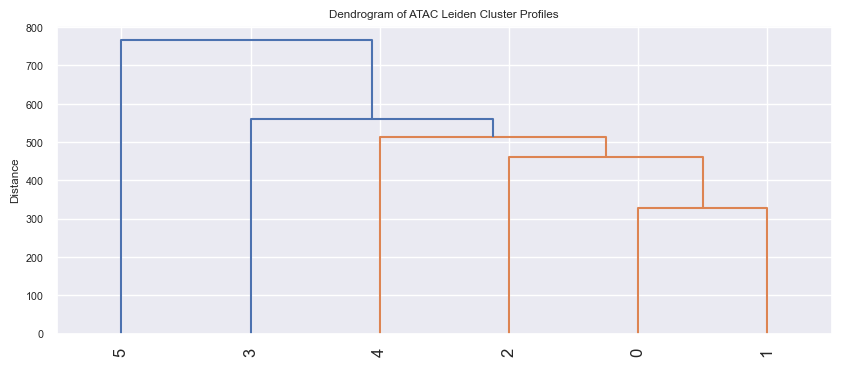

Adjusted Rand Index (RNA vs ATAC Leiden): 0.505
Normalized Mutual Information (RNA vs ATAC Leiden): 0.630


In [13]:
common_cells = ATAC_scores.columns.intersection(RNA_T.index)
valid_cells = common_cells.intersection(qc.index)

missing = set(common_cells) - set(valid_cells)
if missing:
    print(f"! Warning: {len(missing)} cells missing in QC metrics: {list(missing)[:5]}")

ATAC_T = ATAC_scores[valid_cells].T
RNA_T = RNA_T.loc[valid_cells]

common_cells = ATAC_scores.columns.intersection(RNA_T.index) 
lineage = qc.loc[valid_cells, 'Lineage'].str.replace(r"#\d+", "", regex=True)


ATAC_T = ATAC_scores[common_cells].T 
ATAC_T_scaled = pd.DataFrame(
    StandardScaler().fit_transform(ATAC_T),
    index=ATAC_T.index,
    columns=ATAC_T.columns
)

RNA_T = RNA_T.loc[common_cells]
RNA_T_scaled = pd.DataFrame(
    StandardScaler().fit_transform(RNA_T),
    index=RNA_T.index,
    columns=RNA_T.columns
)


adata_atac = sc.AnnData(ATAC_T_scaled)
adata_atac.obs['lineage'] = lineage
sc.pp.pca(adata_atac)
sc.pp.neighbors(adata_atac)
sc.tl.leiden(adata_atac, key_added='leiden_atac')

adata_rna = sc.AnnData(RNA_T_scaled)
adata_rna.obs['lineage'] = lineage
sc.pp.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.leiden(adata_rna, key_added='leiden_rna')

common_cells = adata_rna.obs_names.intersection(adata_atac.obs_names)
leiden_rna_labels = adata_rna.obs.loc[common_cells, 'leiden_rna']
leiden_atac_labels = adata_atac.obs.loc[common_cells, 'leiden_atac']
# Contingency table (RNA vs ATAC)
contingency = pd.crosstab(leiden_rna_labels, leiden_atac_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    contingency,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.5
)
plt.title("Leiden Cluster Overlap: RNA vs ATAC")
plt.xlabel("ATAC Leiden Clusters")
plt.ylabel("RNA Leiden Clusters")
plt.tight_layout()
plt.show()


#dendograms

RNA_profiles = RNA_T_scaled.copy()
RNA_profiles['cluster'] = adata_rna.obs['leiden_rna']
RNA_cluster_avg = RNA_profiles.groupby('cluster').mean()

ATAC_profiles = ATAC_T_scaled.copy()
ATAC_profiles['cluster'] = adata_atac.obs['leiden_atac']
ATAC_cluster_avg = ATAC_profiles.groupby('cluster').mean()

# RNA dendrogram
plt.figure(figsize=(10, 4))
Z_rna = linkage(RNA_cluster_avg, method='average')
dendrogram(Z_rna, labels=RNA_cluster_avg.index, leaf_rotation=90)
plt.title("Dendrogram of RNA Leiden Cluster Profiles")
plt.ylabel("Distance")
plt.show()

# ATAC dendrogram
plt.figure(figsize=(10, 4))
Z_atac = linkage(ATAC_cluster_avg, method='average')
dendrogram(Z_atac, labels=ATAC_cluster_avg.index, leaf_rotation=90)
plt.title("Dendrogram of ATAC Leiden Cluster Profiles")
plt.ylabel("Distance")
plt.show()

ari = adjusted_rand_score(leiden_rna_labels, leiden_atac_labels)
nmi = normalized_mutual_info_score(leiden_rna_labels, leiden_atac_labels)

print(f"Adjusted Rand Index (RNA vs ATAC Leiden): {ari:.3f}")
print(f"Normalized Mutual Information (RNA vs ATAC Leiden): {nmi:.3f}")


now we will compute mds plots leiden atac/rna

C:\Users\helen\AppData\Local\Temp\ipykernel_26096\999358214.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  RNA_cluster_avg = RNA_T_scaled.groupby(adata.obs["leiden"]).mean()
C:\Users\helen\AppData\Local\Temp\ipykernel_26096\999358214.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ATAC_cluster_avg = ATAC_T_scaled.groupby(adata.obs["leiden"]).mean()
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
c:\Users\helen\OneDrive\Documents\GitHub\abT-g

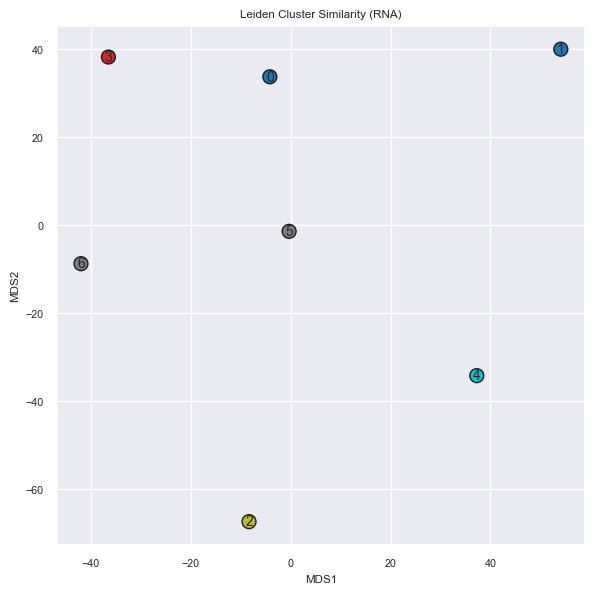

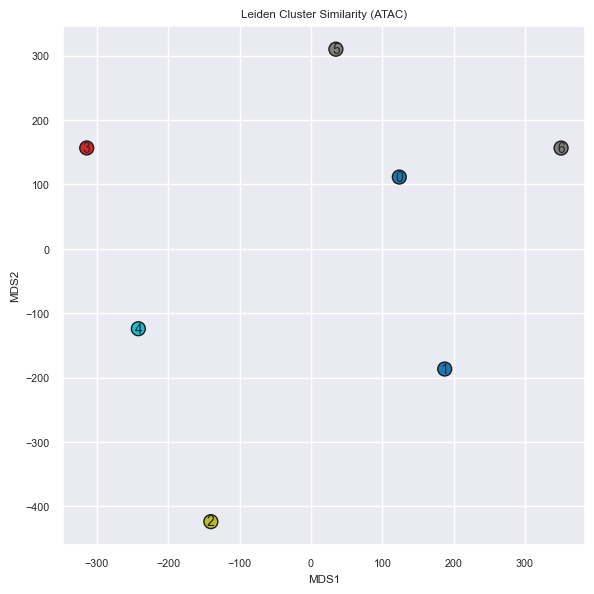

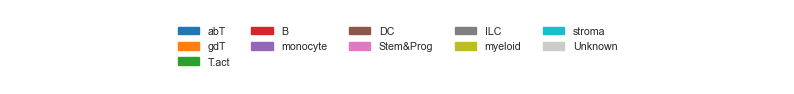

In [18]:
adata_atac = sc.AnnData(ATAC_scores.T)
adata_atac.obs = adata_atac.obs.join(qc, how='left')
lineage = qc.loc[valid_cells, 'Lineage'].str.replace(r"#\d+", "", regex=True)
adata_atac.obs['lineage'] = lineage
sc.pp.neighbors(adata_atac, use_rep="X", n_neighbors=15, metric='euclidean')
sc.tl.leiden(adata_atac, resolution=1.0)

if "leiden" not in adata_atac.obs.columns:
    raise ValueError("Leiden clustering not found in adata.obs")

#mean profiles( grouped by lc)
RNA_cluster_avg = RNA_T_scaled.groupby(adata.obs["leiden"]).mean()
ATAC_cluster_avg = ATAC_T_scaled.groupby(adata.obs["leiden"]).mean()

#pairwise distances
rna_distances = squareform(pdist(RNA_cluster_avg, metric='euclidean'))
atac_distances = squareform(pdist(ATAC_cluster_avg, metric='euclidean'))

# MDS projection
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
rna_mds_coords = mds.fit_transform(rna_distances)
atac_mds_coords = mds.fit_transform(atac_distances)

#lineage color mapping-
qc_lineage_mapping = qc[['CellType', 'Lineage']].drop_duplicates(subset=['CellType'], keep='first')
qc_lineage_mapping.set_index('CellType', inplace=True)

lineage_colors = {
      'abT': '#1f77b4', 'gdT': '#ff7f0e', 'T.act': '#2ca02c',
    'B': '#d62728', 'monocyte': '#9467bd', 'DC': '#8c564b',
    'Stem&Prog': '#e377c2', 'ILC': '#7f7f7f',
    'myeloid': '#bcbd22', 'stroma': '#17becf', 'Unknown': '#cccccc'
}
# lineage in leiden clusters
cluster_lineage = (
    adata.obs.groupby("leiden")["Lineage"]
    .agg(lambda x: x.value_counts().idxmax() if not x.isna().all() else "Unknown")
)

cluster_lineages = cluster_lineage.loc[RNA_cluster_avg.index].fillna("Unknown")
cluster_colors = cluster_lineages.map(lineage_colors).fillna('#cccccc').values
leiden_labels = RNA_cluster_avg.index.astype(str)

# RNA MDS
plt.figure(figsize=(6, 6))
plt.scatter(rna_mds_coords[:, 0], rna_mds_coords[:, 1], c=cluster_colors, edgecolor='k', s=100)
for i, label in enumerate(leiden_labels):
    plt.text(rna_mds_coords[i, 0], rna_mds_coords[i, 1], label, fontsize=10, ha='center', va='center')
plt.title("Leiden Cluster Similarity (RNA)")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ATAC MDS 
plt.figure(figsize=(6, 6))
plt.scatter(atac_mds_coords[:, 0], atac_mds_coords[:, 1], c=cluster_colors, edgecolor='k', s=100)
for i, label in enumerate(leiden_labels):
    plt.text(atac_mds_coords[i, 0], atac_mds_coords[i, 1], label, fontsize=10, ha='center', va='center')
plt.title("Leiden Cluster Similarity (ATAC)")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.grid(True)
plt.tight_layout()
plt.show()

#lineage legend
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=c, label=l) for l, c in lineage_colors.items()]
plt.figure(figsize=(8, 1))
plt.legend(handles=legend_handles, ncol=5, loc='center', frameon=False)
plt.axis('off')
plt.tight_layout()
plt.show()

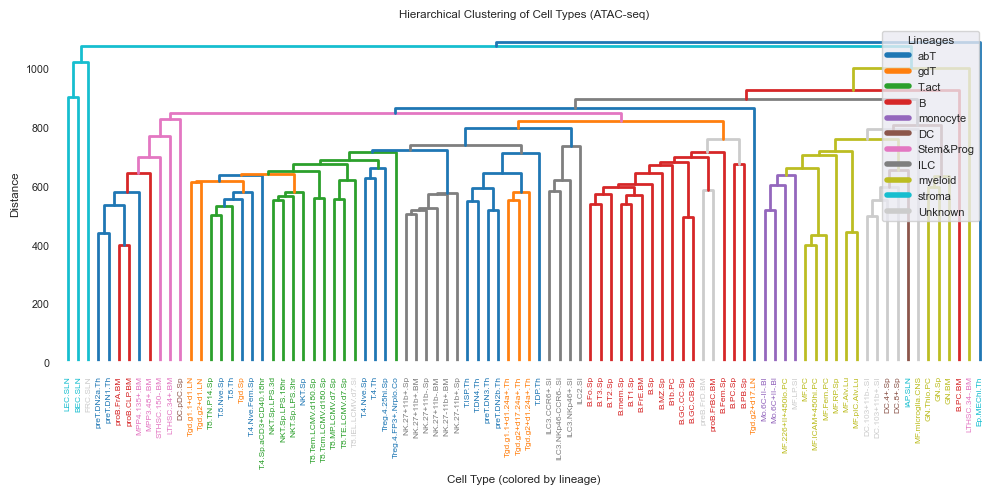

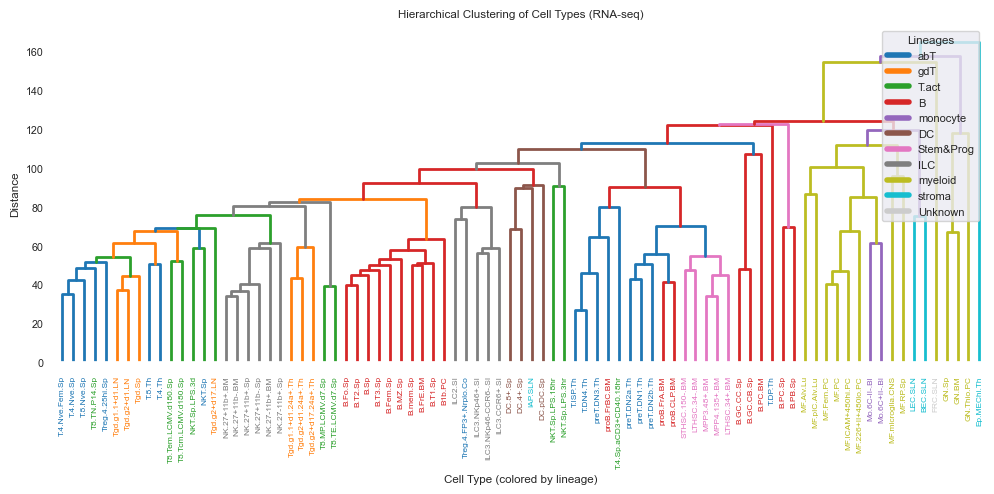

Cophenetic correlation between RNA and ATAC clustering: nan
Cophenetic correlation coefficient (RNA): 0.894
Cophenetic correlation coefficient (ATAC): 0.910


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
from scipy.stats import spearmanr

# Scale and link
scaler = StandardScaler()
ATAC_T_scaled = pd.DataFrame(
    scaler.fit_transform(ATAC_scores_T),
    index=ATAC_scores_T.index,
    columns=ATAC_scores_T.columns
)
linkage_atac = linkage(ATAC_T_scaled, method='average')

RNA_seq_T_scaled = pd.DataFrame(
    scaler.fit_transform(RNA_T),
    index=RNA_T.index,
    columns=RNA_T.columns
)
linkage_RNA = linkage(RNA_seq_T_scaled, method='average')

# Intersect samples
common_samples = RNA_seq_T_scaled.index.intersection(ATAC_T_scaled.index)
RNA_seq_log_scaled_common = RNA_seq_T_scaled.loc[common_samples].sort_index()
ATAC_T_scaled_common = ATAC_T_scaled.loc[common_samples].sort_index()

# Lineage colors
lineage_colors = {
    'abT': '#1f77b4', 'gdT': '#ff7f0e', 'T.act': '#2ca02c',
    'B': '#d62728', 'monocyte': '#9467bd', 'DC': '#8c564b',
    'Stem&Prog': '#e377c2', 'ILC': '#7f7f7f',
    'myeloid': '#bcbd22', 'stroma': '#17becf', 'Unknown': '#cccccc'
}

# Modified dendrogram plotting function
def plot_colored_dendrogram(linkage_matrix, labels, lineage_series, lineage_color_map, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=90,
        leaf_font_size=6,
        color_threshold=0,
        above_threshold_color='none',
        distance_sort='descending',
        no_plot=True  # we will manually plot to control branch coloring
    )
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Extract plot coordinates
    icoord = np.array(dendro['icoord'])
    dcoord = np.array(dendro['dcoord'])
    leaves = dendro['leaves']
    leaf_labels = [labels[i] for i in leaves]
    tick_to_lineage = {lbl: lineage_series.get(lbl, 'Unknown') for lbl in leaf_labels}

    # Manually draw branches
    for xs, ys, leaf_idx in zip(icoord, dcoord, dendro['leaves_color_list']):
        # For each branch (always 4 x-values), identify which leaf is at the ends
        for i in [1, 2]:  # only endpoints of the U-shape (left and right)
            x = xs[i]
            y = ys[i]
            # Find the closest leaf tick
            leaf_pos = int(round((x - 5.0) / 10.0))  # math from scipy dendrogram docs
            if 0 <= leaf_pos < len(leaf_labels):
                label = leaf_labels[leaf_pos]
                lineage = tick_to_lineage[label]
                color = lineage_color_map.get(lineage)
                ax.plot(xs, ys, color=color, linewidth=2)
                break  # only need to color once per segment

    # Now actually draw the full dendrogram to get tick labels
    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=90,
        leaf_font_size=6,
        color_threshold=0,
        above_threshold_color='none',
        distance_sort='descending',
        ax=ax
    )

    # Color tick labels
    tick_labels = ax.get_xmajorticklabels()
    for lbl in tick_labels:
        sample = lbl.get_text()
        lineage = lineage_series.get(sample, 'Unknown')
        lbl.set_color(lineage_color_map.get(lineage, '#cccccc'))

    ax.set_title(title)
    ax.set_xlabel('Cell Type (colored by lineage)')
    ax.set_ylabel('Distance')
    ax.set_ylim(bottom=0)
    ax.grid(False)  # remove background grid

    # Legend
    handles = [plt.Line2D([0], [0], color=c, lw=4) for c in lineage_color_map.values()]
    labels = list(lineage_color_map.keys())
    ax.legend(handles, labels, loc='upper right', fontsize=8, title='Lineages')
    plt.tight_layout()

# Plot dendrogram for ATAC
plot_colored_dendrogram(linkage_atac, ATAC_T_scaled.index.tolist(), adata.obs['Lineage'], lineage_colors, "Hierarchical Clustering of Cell Types (ATAC-seq)")
plt.show()

# Plot dendrogram for RNA
plot_colored_dendrogram(linkage_RNA, RNA_seq_T_scaled.index.tolist(), adata.obs['Lineage'], lineage_colors, "Hierarchical Clustering of Cell Types (RNA-seq)")
plt.show()

# Cophenetic correlation
coph_RNA, _ = cophenet(linkage_RNA, pdist(RNA_seq_T_scaled))
coph_atac, _ = cophenet(linkage_atac, pdist(ATAC_T_scaled))
corr, _ = spearmanr(coph_RNA, coph_atac)
print(f"Cophenetic correlation between RNA and ATAC clustering: {corr:.3f}")
print(f"Cophenetic correlation coefficient (RNA): {coph_RNA.mean():.3f}")
print(f"Cophenetic correlation coefficient (ATAC): {coph_atac.mean():.3f}")


Filtered from 6451 to 6271 features (variance threshold 0.1)
Filtered from 363046 to 361804 features (variance threshold 0.1)
Adjusted Rand Index (ARI): 0.4236
Fowlkes-Mallows Index (FMI): 0.5017


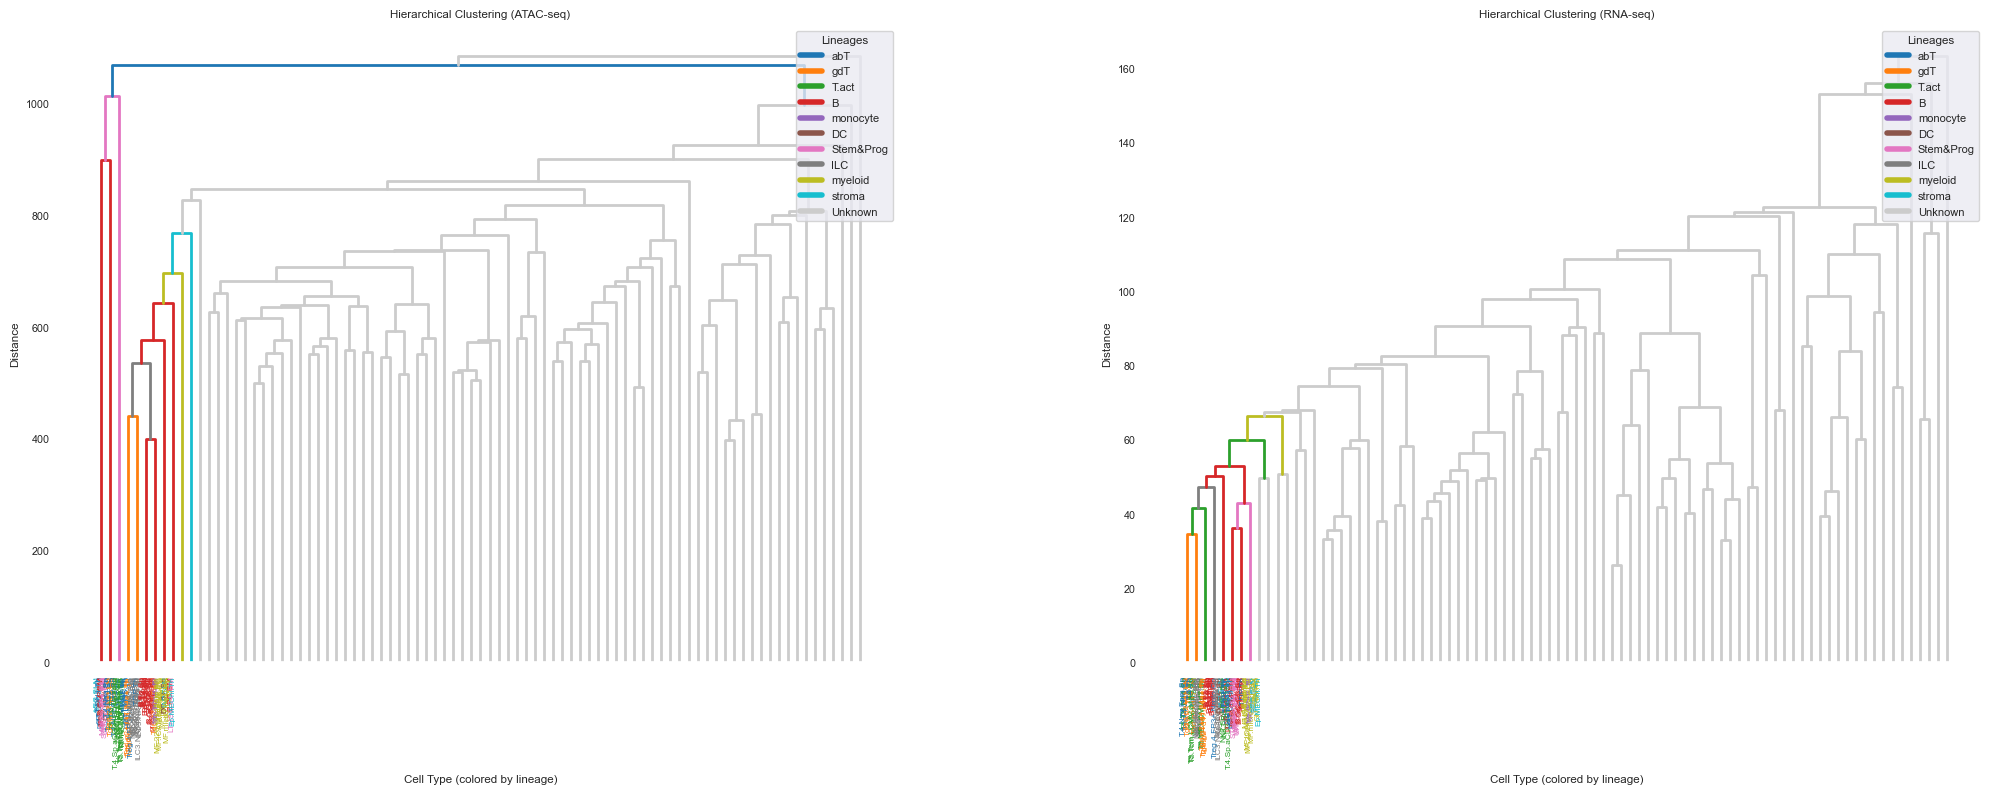

In [20]:
#DENDoGRAMS 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score

# Lineage color map
lineage_colors = {
    'abT': '#1f77b4', 'gdT': '#ff7f0e', 'T.act': '#2ca02c',
    'B': '#d62728', 'monocyte': '#9467bd', 'DC': '#8c564b',
    'Stem&Prog': '#e377c2', 'ILC': '#7f7f7f',
    'myeloid': '#bcbd22', 'stroma': '#17becf', 'Unknown': '#cccccc'
}

# Variance filter
def filter_low_variance(df, threshold=0.1):
    selector = VarianceThreshold(threshold=threshold)
    filtered_array = selector.fit_transform(df)
    filtered_cols = df.columns[selector.get_support()]
    filtered_df = pd.DataFrame(filtered_array, index=df.index, columns=filtered_cols)
    print(f"Filtered from {df.shape[1]} to {filtered_df.shape[1]} features (variance threshold {threshold})")
    return filtered_df

# Dendrogram plotting function with synchronized tick & branch colors
def plot_colored_dendrogram(linkage_matrix, labels, lineage_series, lineage_color_map, title):
    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=90,
        leaf_font_size=6,
        color_threshold=0,
        above_threshold_color='grey',
        distance_sort='descending',
        no_plot=True  # We manually plot
    )

    ax = plt.gca()
    ax.set_facecolor("white")  # Remove gray background
    plt.grid(False)            # Remove grid

    # Map leaves to lineages
    leaves = dendro['leaves']
    leaf_labels = [labels[i] for i in leaves]
    leaf_lineages = [lineage_series.get(lbl, 'Unknown') for lbl in leaf_labels]
    leaf_colors = [lineage_color_map.get(lin, '#cccccc') for lin in leaf_lineages]

    # Plot branches with color of corresponding leftmost leaf
    icoord = np.array(dendro['icoord'])
    dcoord = np.array(dendro['dcoord'])

    for i, (xs, ys) in enumerate(zip(icoord, dcoord)):
        # Determine leftmost leaf index in current branch
        left_leaf_idx = int((xs[0] + xs[1]) / 2)
        left_leaf_order = int(round(left_leaf_idx))
        if left_leaf_order >= len(leaf_colors):
            color = '#cccccc'
        else:
            color = leaf_colors[left_leaf_order]
        ax.plot(xs, ys, color=color, linewidth=2)

    # Plot tick labels with color
    ax.set_xticks(range(len(leaf_labels)))
    ax.set_xticklabels(leaf_labels, rotation=90, fontsize=6)
    for tick_label in ax.get_xticklabels():
        sample = tick_label.get_text()
        lineage = lineage_series.get(sample, 'Unknown')
        tick_label.set_color(lineage_color_map.get(lineage, '#cccccc'))

    plt.title(title)
    plt.xlabel('Cell Type (colored by lineage)')
    plt.ylabel('Distance')
    plt.ylim(bottom=0)
    plt.tight_layout()

    # Add legend
    handles = [plt.Line2D([0], [0], color=c, lw=4) for c in lineage_color_map.values()]
    legend_labels = list(lineage_color_map.keys())
    ax.legend(handles, legend_labels, loc='upper right', fontsize=8, title='Lineages')

# === Data ===
lineages = adata.obs['Lineage']
clusters = adata.obs['leiden']

common_samples = adata.obs_names.intersection(data['RNA_seq_T'].index).intersection(data['norm_scores'].columns)
RNA_T = data['RNA_seq_T'].loc[common_samples]
ATAC_scores = data['norm_scores'].loc[:, common_samples].T

RNA_filtered = filter_low_variance(RNA_T)
ATAC_filtered = filter_low_variance(ATAC_scores)

scaler = StandardScaler()
RNA_scaled = pd.DataFrame(scaler.fit_transform(RNA_filtered), index=RNA_filtered.index, columns=RNA_filtered.columns)
ATAC_scaled = pd.DataFrame(scaler.fit_transform(ATAC_filtered), index=ATAC_filtered.index, columns=ATAC_filtered.columns)

# Sort samples by lineage
sorted_samples = lineages.loc[RNA_scaled.index].sort_values().index
RNA_sorted = RNA_scaled.loc[sorted_samples]
ATAC_sorted = ATAC_scaled.loc[sorted_samples]

# Linkage
linkage_RNA = linkage(RNA_sorted, method='average', metric='euclidean')
linkage_ATAC = linkage(ATAC_sorted, method='average', metric='euclidean')

# ARI and FMI
valid_mask = (~lineages.loc[common_samples].isna()) & (~clusters.loc[common_samples].isna())
valid_samples = common_samples[valid_mask]
ari = adjusted_rand_score(lineages.loc[valid_samples], clusters.loc[valid_samples])
fmi = fowlkes_mallows_score(lineages.loc[valid_samples], clusters.loc[valid_samples])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.sca(axes[0])
plot_colored_dendrogram(linkage_ATAC, ATAC_sorted.index.tolist(), lineages, lineage_colors, 'Hierarchical Clustering (ATAC-seq)')

plt.sca(axes[1])
plot_colored_dendrogram(linkage_RNA, RNA_sorted.index.tolist(), lineages, lineage_colors, 'Hierarchical Clustering (RNA-seq)')

plt.subplots_adjust(wspace=0.3)
plt.show()


In [21]:
print(adata.obs.columns)

Index(['Lineage_x', 'leiden', 'CellType', 'kmeans12', 'Lineage_y', 'Lineage'], dtype='object')


Filtered from 6451 to 6271 features (variance threshold 0.1)
Filtered from 363046 to 361804 features (variance threshold 0.1)
Adjusted Rand Index (ARI): 0.4236
Fowlkes-Mallows Index (FMI): 0.5017


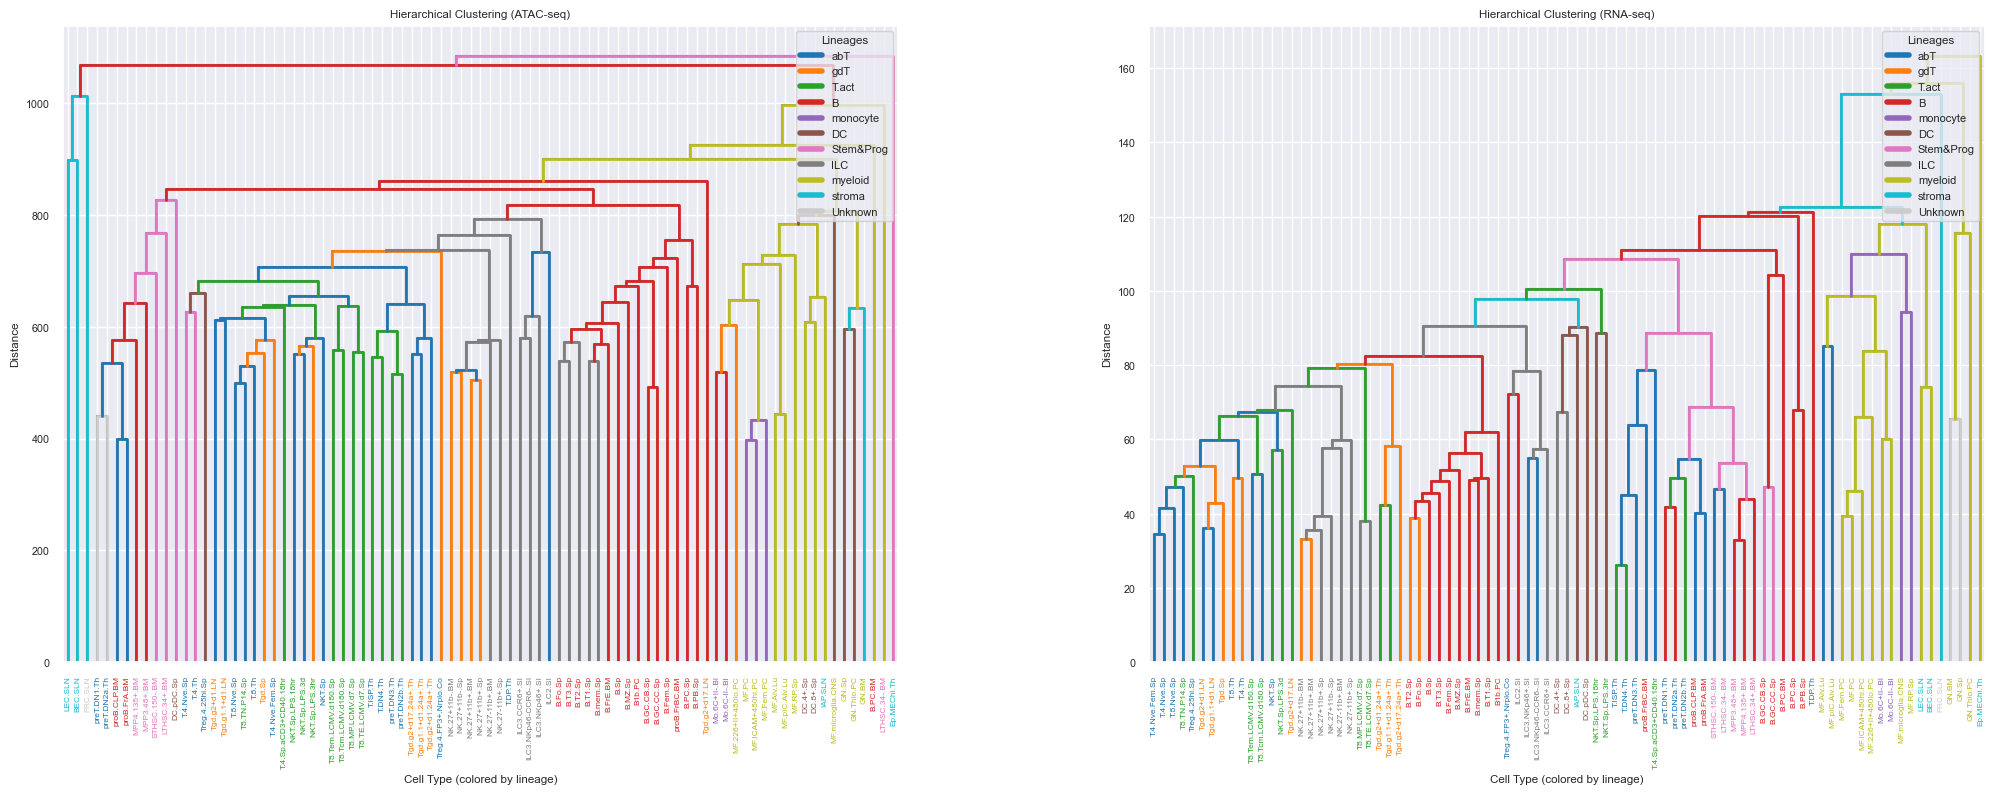

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score

# Use your data
lineages = adata.obs['Lineage']
clusters = adata.obs['leiden']

common_samples = adata.obs_names.intersection(data['RNA_seq_T'].index).intersection(data['norm_scores'].columns)

RNA_T = data['RNA_seq_T'].loc[common_samples]
ATAC_scores = data['norm_scores'].loc[:, common_samples].T  # samples x peaks

# Variance filter
def filter_low_variance(df, threshold=0.1):
    selector = VarianceThreshold(threshold=threshold)
    filtered_array = selector.fit_transform(df)
    filtered_cols = df.columns[selector.get_support()]
    filtered_df = pd.DataFrame(filtered_array, index=df.index, columns=filtered_cols)
    print(f"Filtered from {df.shape[1]} to {filtered_df.shape[1]} features (variance threshold {threshold})")
    return filtered_df

RNA_filtered = filter_low_variance(RNA_T, threshold=0.1)
ATAC_filtered = filter_low_variance(ATAC_scores, threshold=0.1)

# Scaling
scaler = StandardScaler()
RNA_scaled = pd.DataFrame(scaler.fit_transform(RNA_filtered), index=RNA_filtered.index, columns=RNA_filtered.columns)
ATAC_scaled = pd.DataFrame(scaler.fit_transform(ATAC_filtered), index=ATAC_filtered.index, columns=ATAC_filtered.columns)

# Sort by lineage to ensure consistent coloring
sorted_samples = lineages.loc[RNA_scaled.index].sort_values().index
RNA_sorted = RNA_scaled.loc[sorted_samples]
ATAC_sorted = ATAC_scaled.loc[sorted_samples]

# Linkage
linkage_RNA = linkage(RNA_sorted, method='average', metric='euclidean')
linkage_ATAC = linkage(ATAC_sorted, method='average', metric='euclidean')

# ARI/FMI scores
valid_mask = (~lineages.loc[common_samples].isna()) & (~clusters.loc[common_samples].isna())
valid_samples = common_samples[valid_mask]
ari = adjusted_rand_score(lineages.loc[valid_samples], clusters.loc[valid_samples])
fmi = fowlkes_mallows_score(lineages.loc[valid_samples], clusters.loc[valid_samples])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")

# Lineage color map
lineage_colors = {
    'abT': '#1f77b4', 'gdT': '#ff7f0e', 'T.act': '#2ca02c',
    'B': '#d62728', 'monocyte': '#9467bd', 'DC': '#8c564b',
    'Stem&Prog': '#e377c2', 'ILC': '#7f7f7f',
    'myeloid': '#bcbd22', 'stroma': '#17becf', 'Unknown': '#cccccc'
}

# Dendrogram plotting function
def plot_colored_dendrogram(linkage_matrix, labels, lineage_series, lineage_color_map, title):
    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=90,
        leaf_font_size=6,
        color_threshold=0,
        above_threshold_color='grey',
        distance_sort='descending'
    )
    
    ax = plt.gca()
    tick_labels = ax.get_xmajorticklabels()

    # Color tick labels by lineage
    for lbl in tick_labels:
        sample = lbl.get_text()
        lineage = lineage_series.get(sample, 'Unknown')
        lbl.set_color(lineage_color_map.get(lineage, '#cccccc'))

    # Color branches manually by lineage of leftmost leaf
    icoord = np.array(dendro['icoord'])
    dcoord = np.array(dendro['dcoord'])
    leaves = dendro['leaves']
    leaf_order = [labels[i] for i in leaves]
    leaf_lineages = [lineage_series.get(s, 'Unknown') for s in leaf_order]
    leaf_colors = [lineage_color_map.get(lin, '#cccccc') for lin in leaf_lineages]

    for xs, ys, color in zip(icoord, dcoord, leaf_colors):
        ax.plot(xs, ys, color=color, linewidth=2)

    plt.title(title)
    plt.xlabel('Cell Type (colored by lineage)')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.ylim(bottom=0)

    # Add legend
    handles = [plt.Line2D([0], [0], color=c, lw=4) for c in lineage_color_map.values()]
    labels = list(lineage_color_map.keys())
    ax.legend(handles, labels, loc='upper right', fontsize=8, title='Lineages')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.sca(axes[0])
plot_colored_dendrogram(linkage_ATAC, ATAC_sorted.index.tolist(), lineages, lineage_colors, 'Hierarchical Clustering (ATAC-seq)')

plt.sca(axes[1])
plot_colored_dendrogram(linkage_RNA, RNA_sorted.index.tolist(), lineages, lineage_colors, 'Hierarchical Clustering (RNA-seq)')
plt.subplots_adjust(wspace=0.3)
plt.show()

